In [1]:
# Linear regression on ranks for top up regulated cell types with sampled tumor fraction

In [18]:
# Load packages
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# for PCC and it's scatter plot
from scipy import stats
import seaborn as sns
from matplotlib import cm
import textwrap
import os

In [122]:
data = pd.read_csv("/mnt/DATA3/timo/centers/main/body/outputs/combined_518_FCC_final_old.csv")
# data['cell_type_tissue'] = data['cell_type'].str.replace('RNA.', '', regex=False)
compartment_map = pd.read_csv("/mnt/DATA3/timo/data/compartment_map.csv")
data

sample             status      tfx gender                                   cell_type_tissue  correlation  rank
0       EE88247        Lung Cancer  0.06508      M                       mature NK T cell_Bone Marrow    -0.137445     1
1       EE88247        Lung Cancer  0.06508      M                             type I NK T cell_Blood    -0.131413     2
2       EE88247        Lung Cancer  0.06508      M                             mature NK T cell_Blood    -0.131145     3
3       EE88247        Lung Cancer  0.06508      M                                 naive B cell_Blood    -0.130540     4
4       EE88247        Lung Cancer  0.06508      M  CD8 positive alpha beta cytokine secreting eff...    -0.129783     5
...         ...                ...      ...    ...                                                ...          ...   ...
231541  EE87867  Colorectal Cancer  0.02104      M                    bladder urothelial cell_Bladder     0.004231   443
231542  EE87867  Colorectal Cancer  0.02104      M       acinar cell of salivary gland_Salivary Gland     0.009547   444
231543  EE87867  Colorectal Cancer  0.02104      M                    type B pancreatic cell_Pancreas     0.009896   445
231544  EE87867  Colorectal Cancer  0.02104      M                                   stromal cell_Eye     0.012131   446
231545  EE87867  Colorectal Cancer  0.02104      M                                keratinocyte_Tongue     0.032794   447

[231546 rows x 7 columns]

In [3]:
## outliers
# remove EE87821 (breast cancer) and EE88267 (ovarian cancer) bc too high tfx, around 0.35
# and remove EE87787 bile duct cancer having tfx of 0.068 
# List of EE numbers to exclude
exclude_numbers = ["EE87821", "EE88267", "EE87787"]

# Filter out rows where 'sample' column matches the excluded values
data = data[~data["sample"].isin(exclude_numbers)]

In [4]:
data.shape

(225165, 7)

In [123]:
cancer_types = list(data["status"].unique())
cancer_types.remove('Healthy')
print(cancer_types)

['Lung Cancer', 'Breast Cancer', 'Pancreatic Cancer', 'Ovarian Cancer', 'Bile Duct Cancer', 'Colorectal Cancer', 'Gastric cancer']


In [6]:
# data.groupby('sample')['cell_type'].nunique()

In [124]:
len(data["cell_type_tissue"].unique())

447

In [125]:
cancer_types

['Lung Cancer',
 'Breast Cancer',
 'Pancreatic Cancer',
 'Ovarian Cancer',
 'Bile Duct Cancer',
 'Colorectal Cancer',
 'Gastric cancer']

In [126]:
dic = {}
for cancer_type in cancer_types:
    # print(cancer_type)
    gender = data[data["status"] == cancer_type]["gender"].unique()
    subset_data = data[(data['status'].isin(["Healthy", cancer_type])) & (data['gender'].isin(gender))]

    # Initialize an empty list to store results
    subdic = {}

    for cell_type_oi in set(subset_data["cell_type_tissue"]):
        # print(cell_type_oi)
        subsub= subset_data[subset_data["cell_type_tissue"]==cell_type_oi]
        # take inverted rank for PCC calculation
        subsub_copy = subsub.copy()
        subsub_copy['inverted_ranks'] = len(data["cell_type_tissue"].unique()) - subsub['rank'] # 447 - rank
        # Calculate PCC and p-value
        pcc_inv, p_value = stats.pearsonr(subsub_copy['tfx'], subsub_copy['inverted_ranks'])
        subdic[cell_type_oi] = {'PCC': pcc_inv, 'p_value': p_value, 'df':subsub}

    dic[cancer_type] = subdic
print("Done.")

Done.


In [127]:
# take for each cancer type the cells having top 10 lowest and highest PCC values for plotting
plot_dic = {}

for cancer_type in dic.keys():
    sub_dic = dic[cancer_type]
    
    # Extract all 'PCC' values along with their respective cell types
    pcc_values = [(cell_type, v['PCC']) for cell_type, v in dic[cancer_type].items()]

    # Sort the list by PCC value in descending order
    sorted_pcc = sorted(pcc_values, key=lambda x: x[1], reverse=True)

    # Get the top 10 highest PCC values and their associated cell types
    top_10_highest_pcc = sorted_pcc[:10]

    # Get the top 10 lowest PCC values and their associated cell types (reverse the sorting order)
    top_10_lowest_pcc = sorted_pcc[-10:]#[::-1] for reversed order
    
    cells_lowest_highest_pcc = (top_10_highest_pcc+top_10_lowest_pcc)
    # Extract the cell types from the list
    cell_types_to_select = [cell for cell, pcc in cells_lowest_highest_pcc]

    # Filter the sub-dictionary to include only the selected cells
    filtered_cancer_subdic = {cell_type: sub_dic[cell_type] 
                                         for cell_type in cell_types_to_select 
                                         if cell_type in sub_dic}
    plot_dic[cancer_type] = filtered_cancer_subdic


In [132]:
# Initialize an empty list to store data
data = []

# Iterate over each cancer type
for cancer_type, sub_dic in dic.items():
    # Convert the nested dictionary into a list of tuples
    df_entries = [(cancer_type, cell_type, values['PCC'], values['p_value']) 
                  for cell_type, values in sub_dic.items()]
    
    # Create a DataFrame
    df = pd.DataFrame(df_entries, columns=['cancer_type', 'cell_type', 'PCC', 'p_value'])

    # # Select the top 25 highest and lowest PCC values
    # top_25_highest = df.nlargest(25, 'PCC')
    # top_25_lowest = df.nsmallest(25, 'PCC')
    
    # # Append selected data to the list
    # data.extend(top_25_highest.values.tolist())
    # data.extend(top_25_lowest.values.tolist())

    data.extend(df_entries)

# Convert the collected data into a DataFrame
pcc_df = pd.DataFrame(data, columns=['CancerType', 'cell_type', 'PCC', 'p_value'])

# Display the resulting DataFrame
pcc_df

CancerType                                    cell_type       PCC       p_value
0        Lung Cancer                           naive B cell_Blood  0.040671  4.663558e-01
1        Lung Cancer                             thymocyte_Thymus  0.134109  1.587399e-02
2        Lung Cancer      duodenum glandular cell_Small Intestine  0.012419  8.240446e-01
3        Lung Cancer            bronchial smooth muscle cell_Lung  0.060271  2.801510e-01
4        Lung Cancer  large intestine goblet cell_Large Intestine -0.002732  9.609844e-01
...              ...                                          ...       ...           ...
3124  Gastric cancer                  goblet cell_Small Intestine  0.334176  1.713105e-08
3125  Gastric cancer             epithelial cell of uterus_Uterus  0.327306  3.469669e-08
3126  Gastric cancer        erythroid progenitor cell_Bone Marrow -0.200176  9.207556e-04
3127  Gastric cancer                          plasma cell_Trachea -0.218766  2.847937e-04
3128  Gastric cancer              bladder urothelial cell_Bladder  0.458936  1.599196e-15

[3129 rows x 4 columns]

In [133]:
# pcc_df.to_csv("/mnt/DATA3/timo/centers/main/body/outputs/top_highest_lowest_pcc_values.csv", index=False)

Lung Cancer
Breast Cancer
Pancreatic Cancer
Ovarian Cancer
Bile Duct Cancer
Colorectal Cancer
Gastric cancer


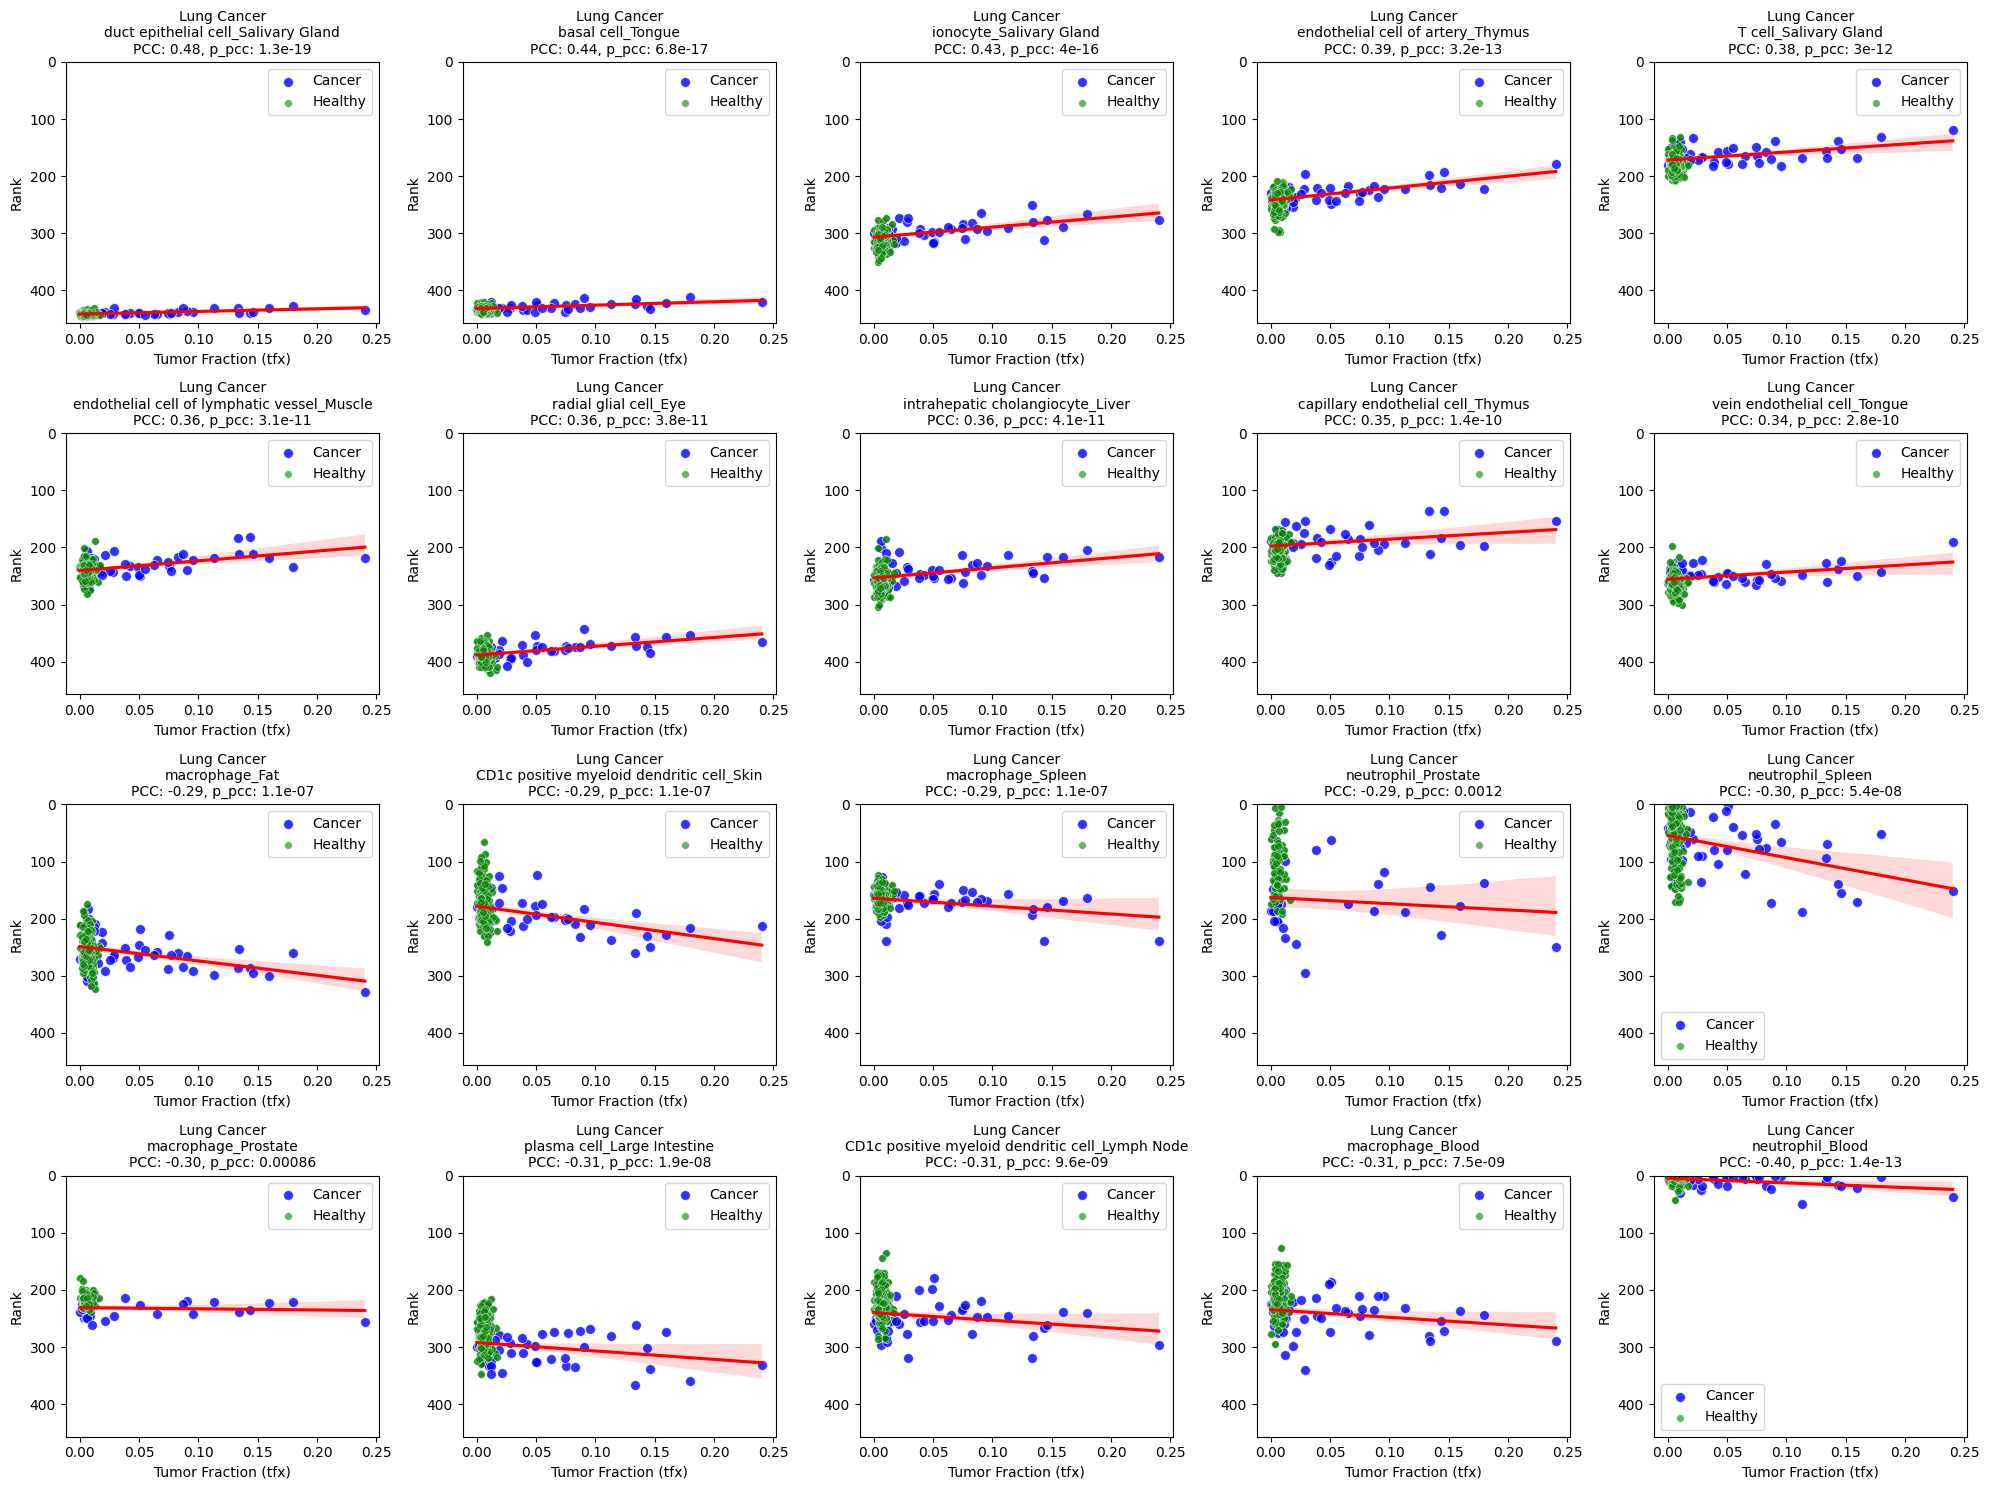

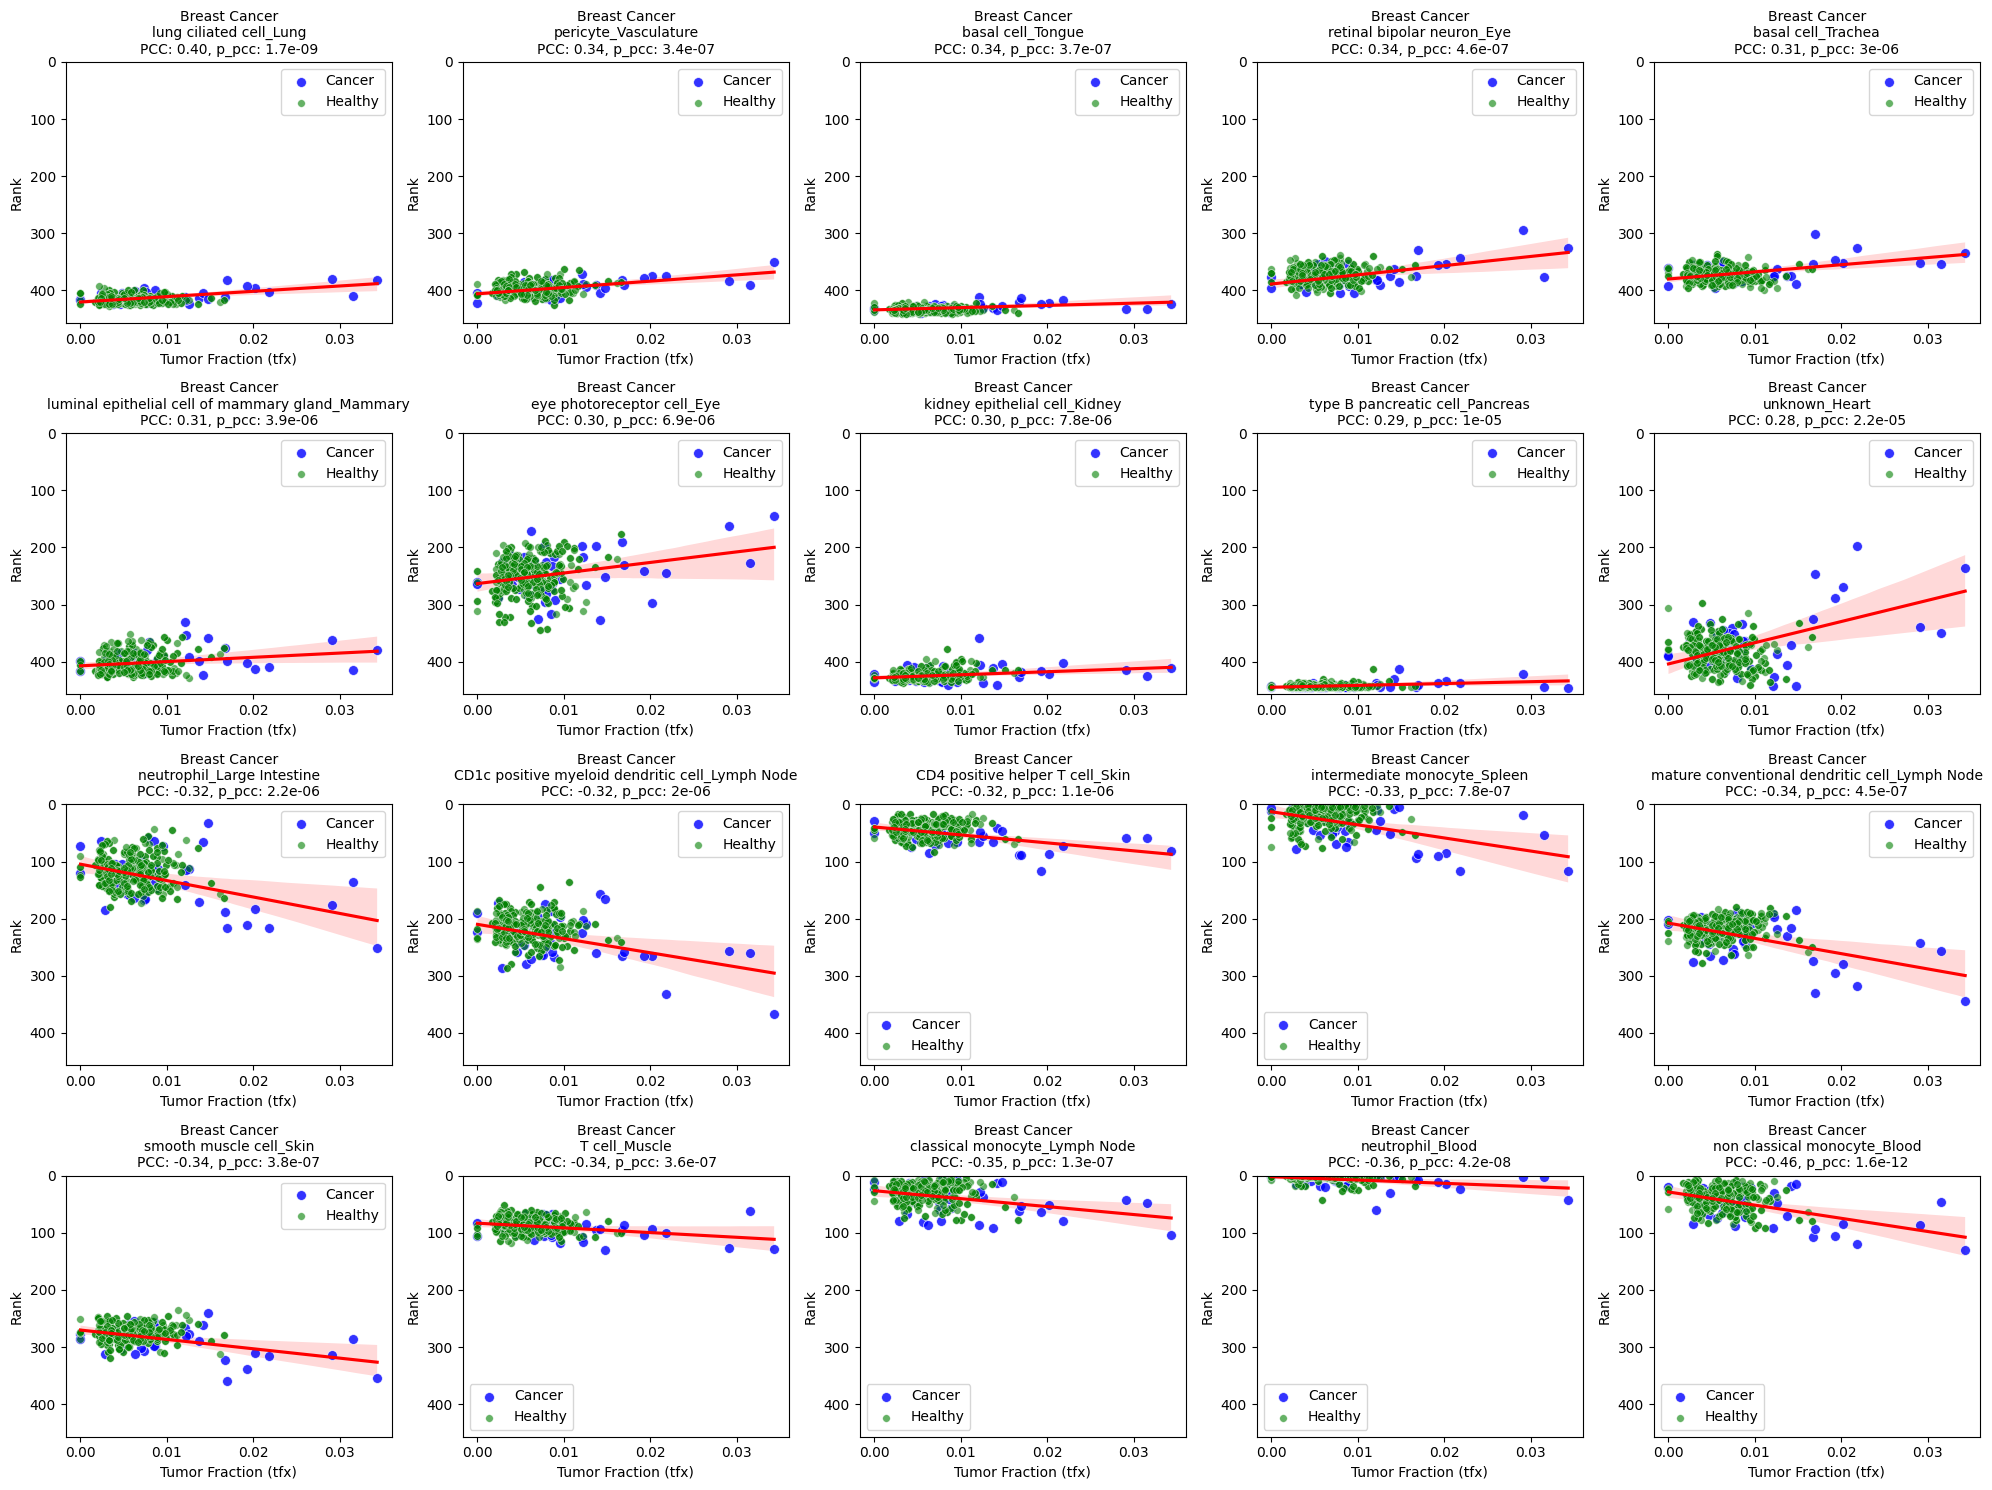

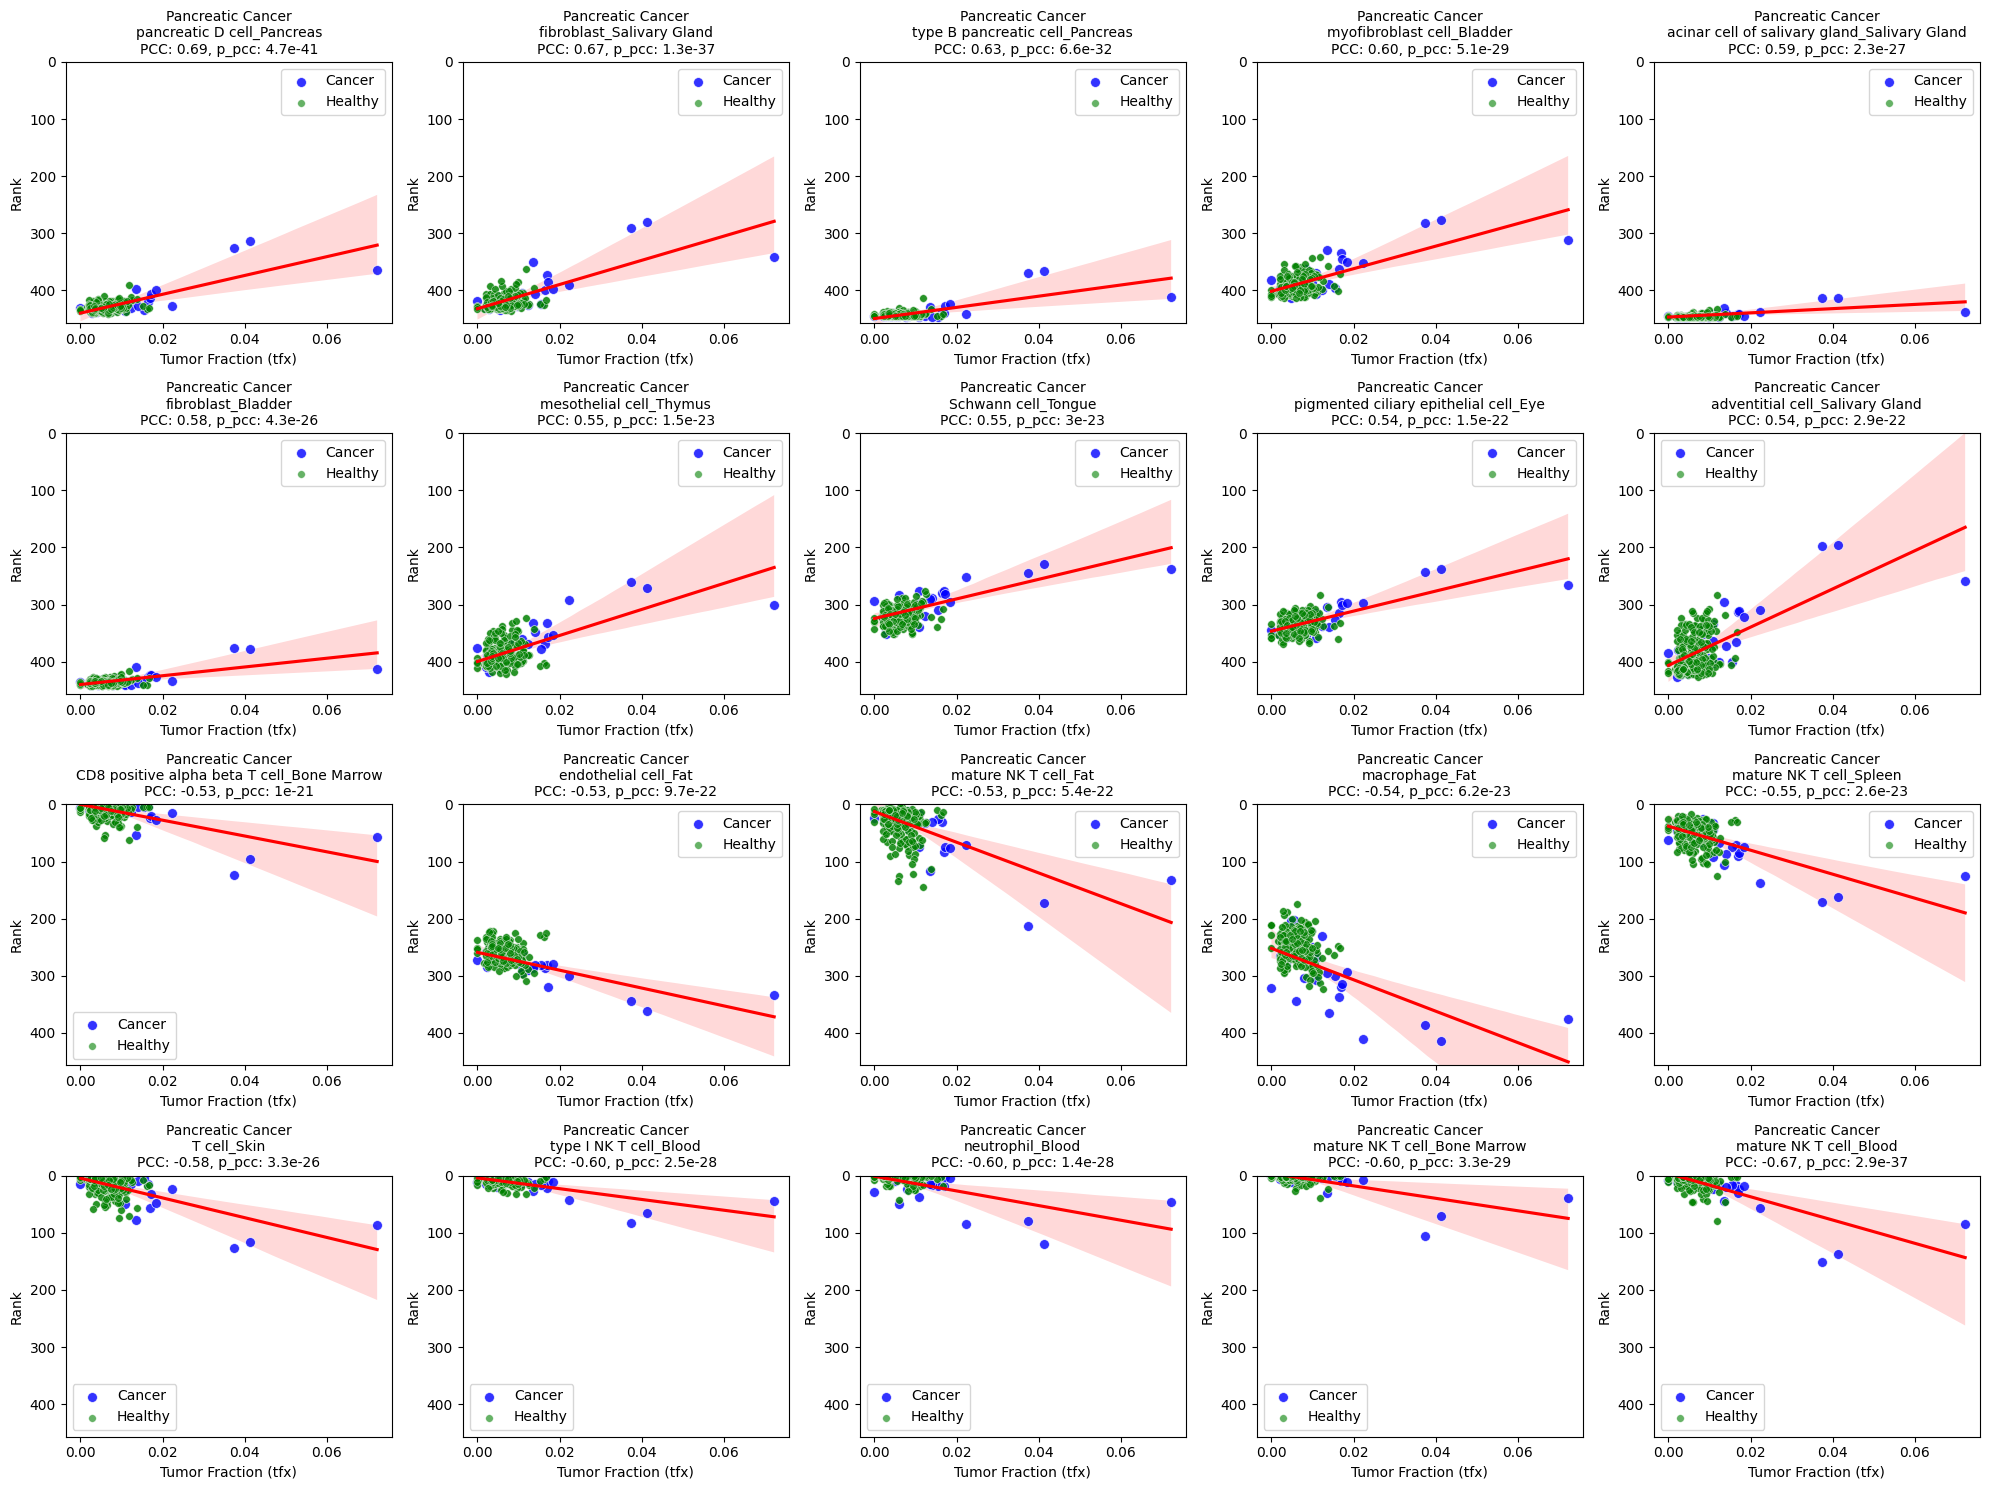

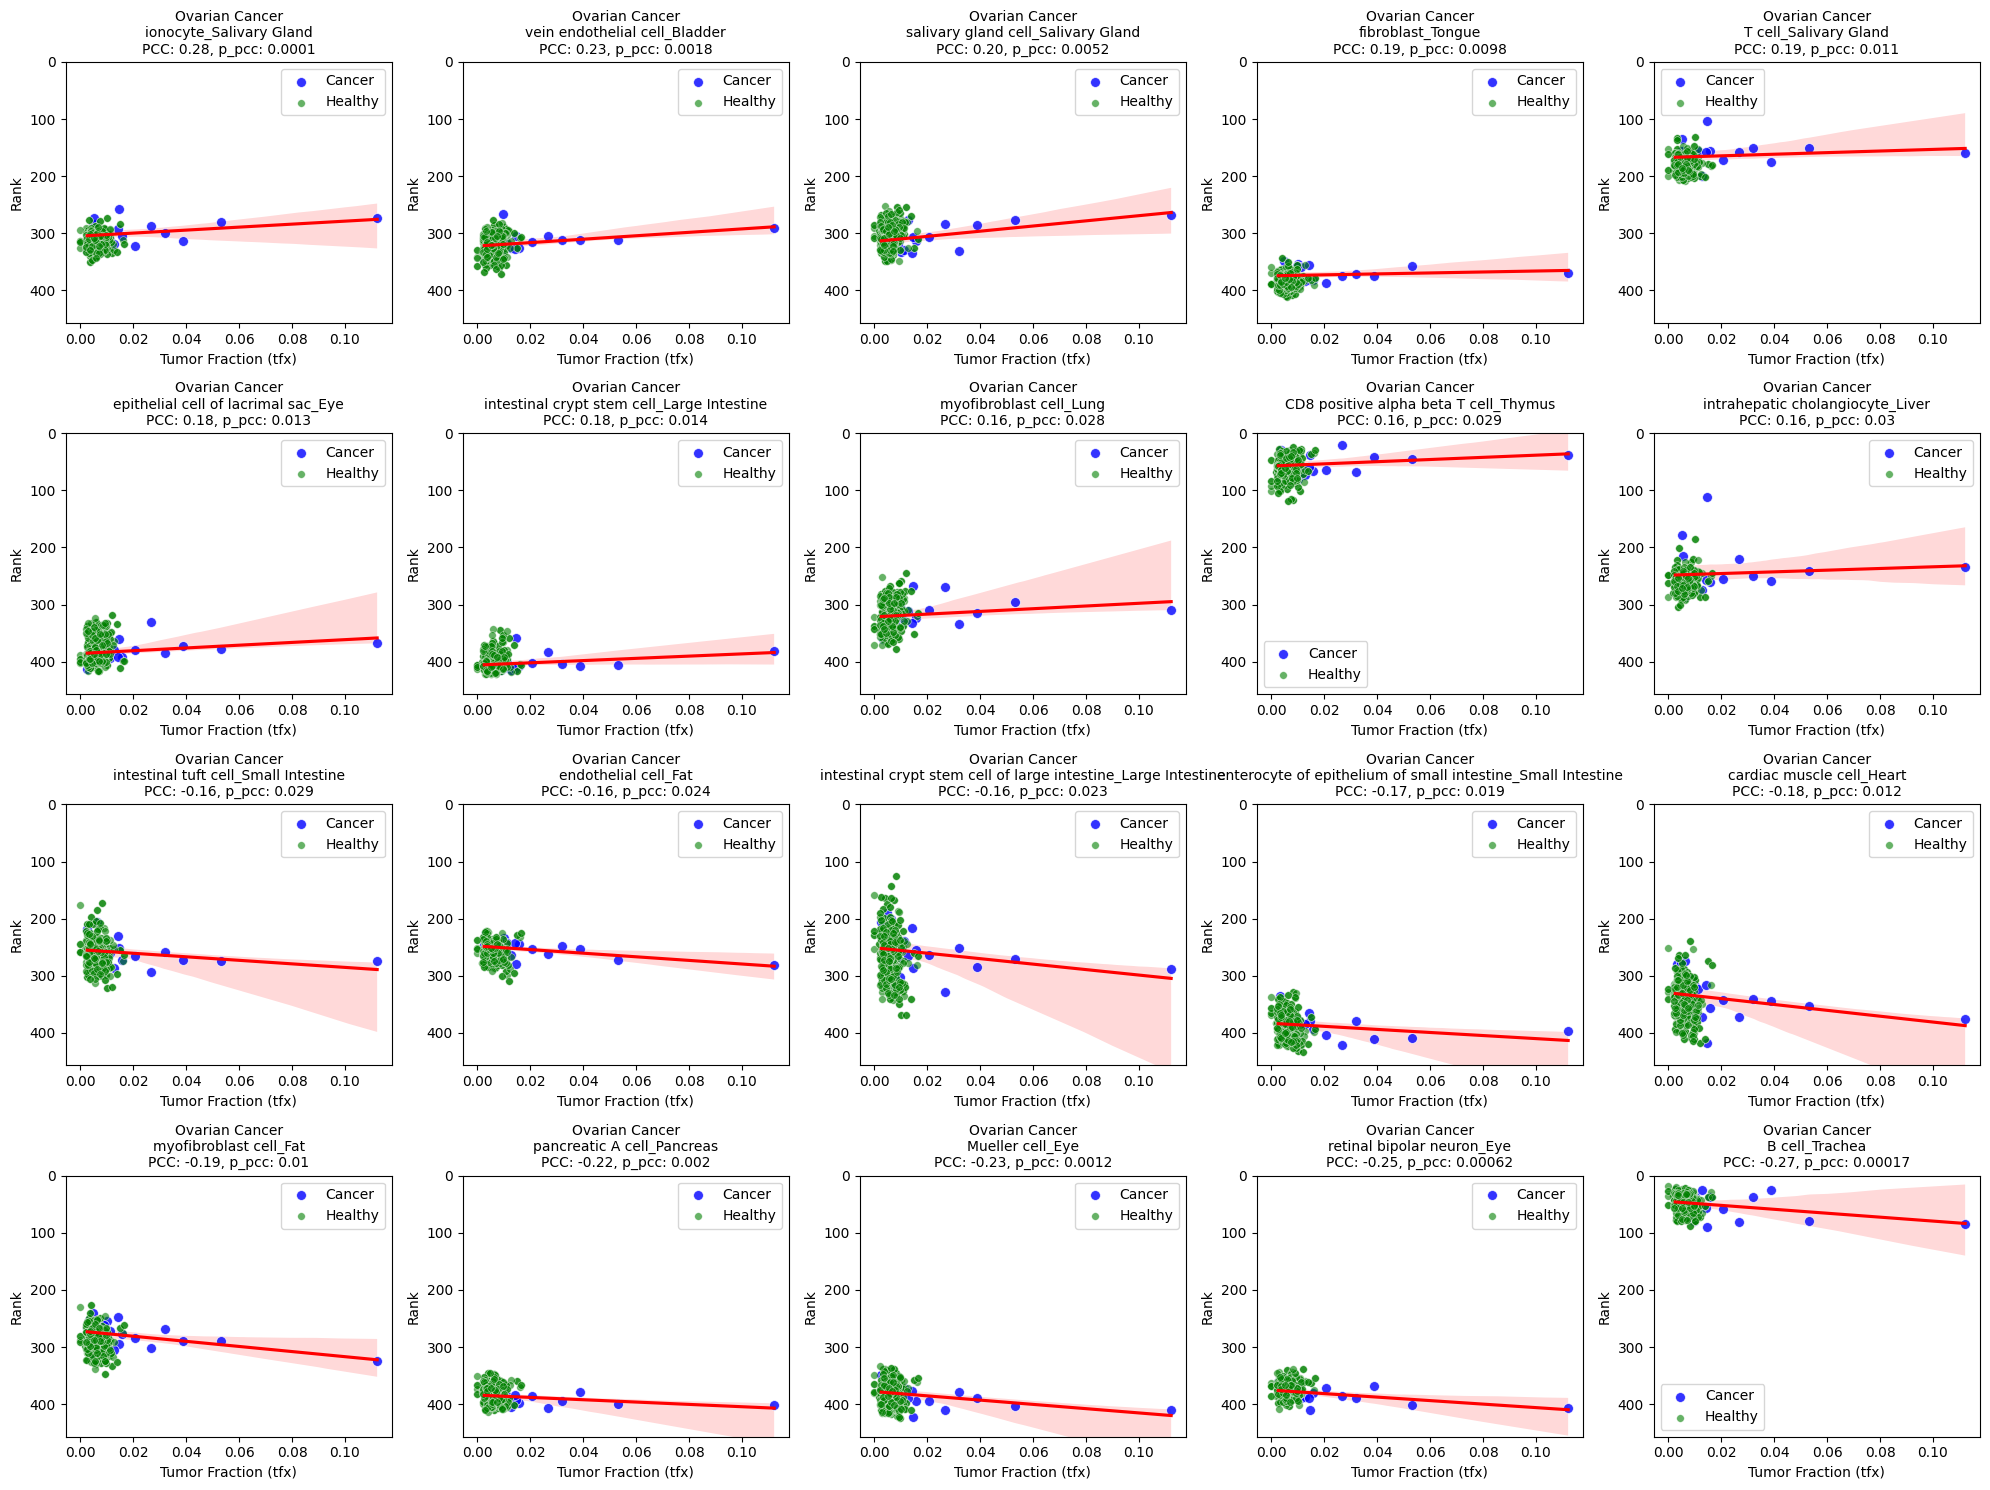

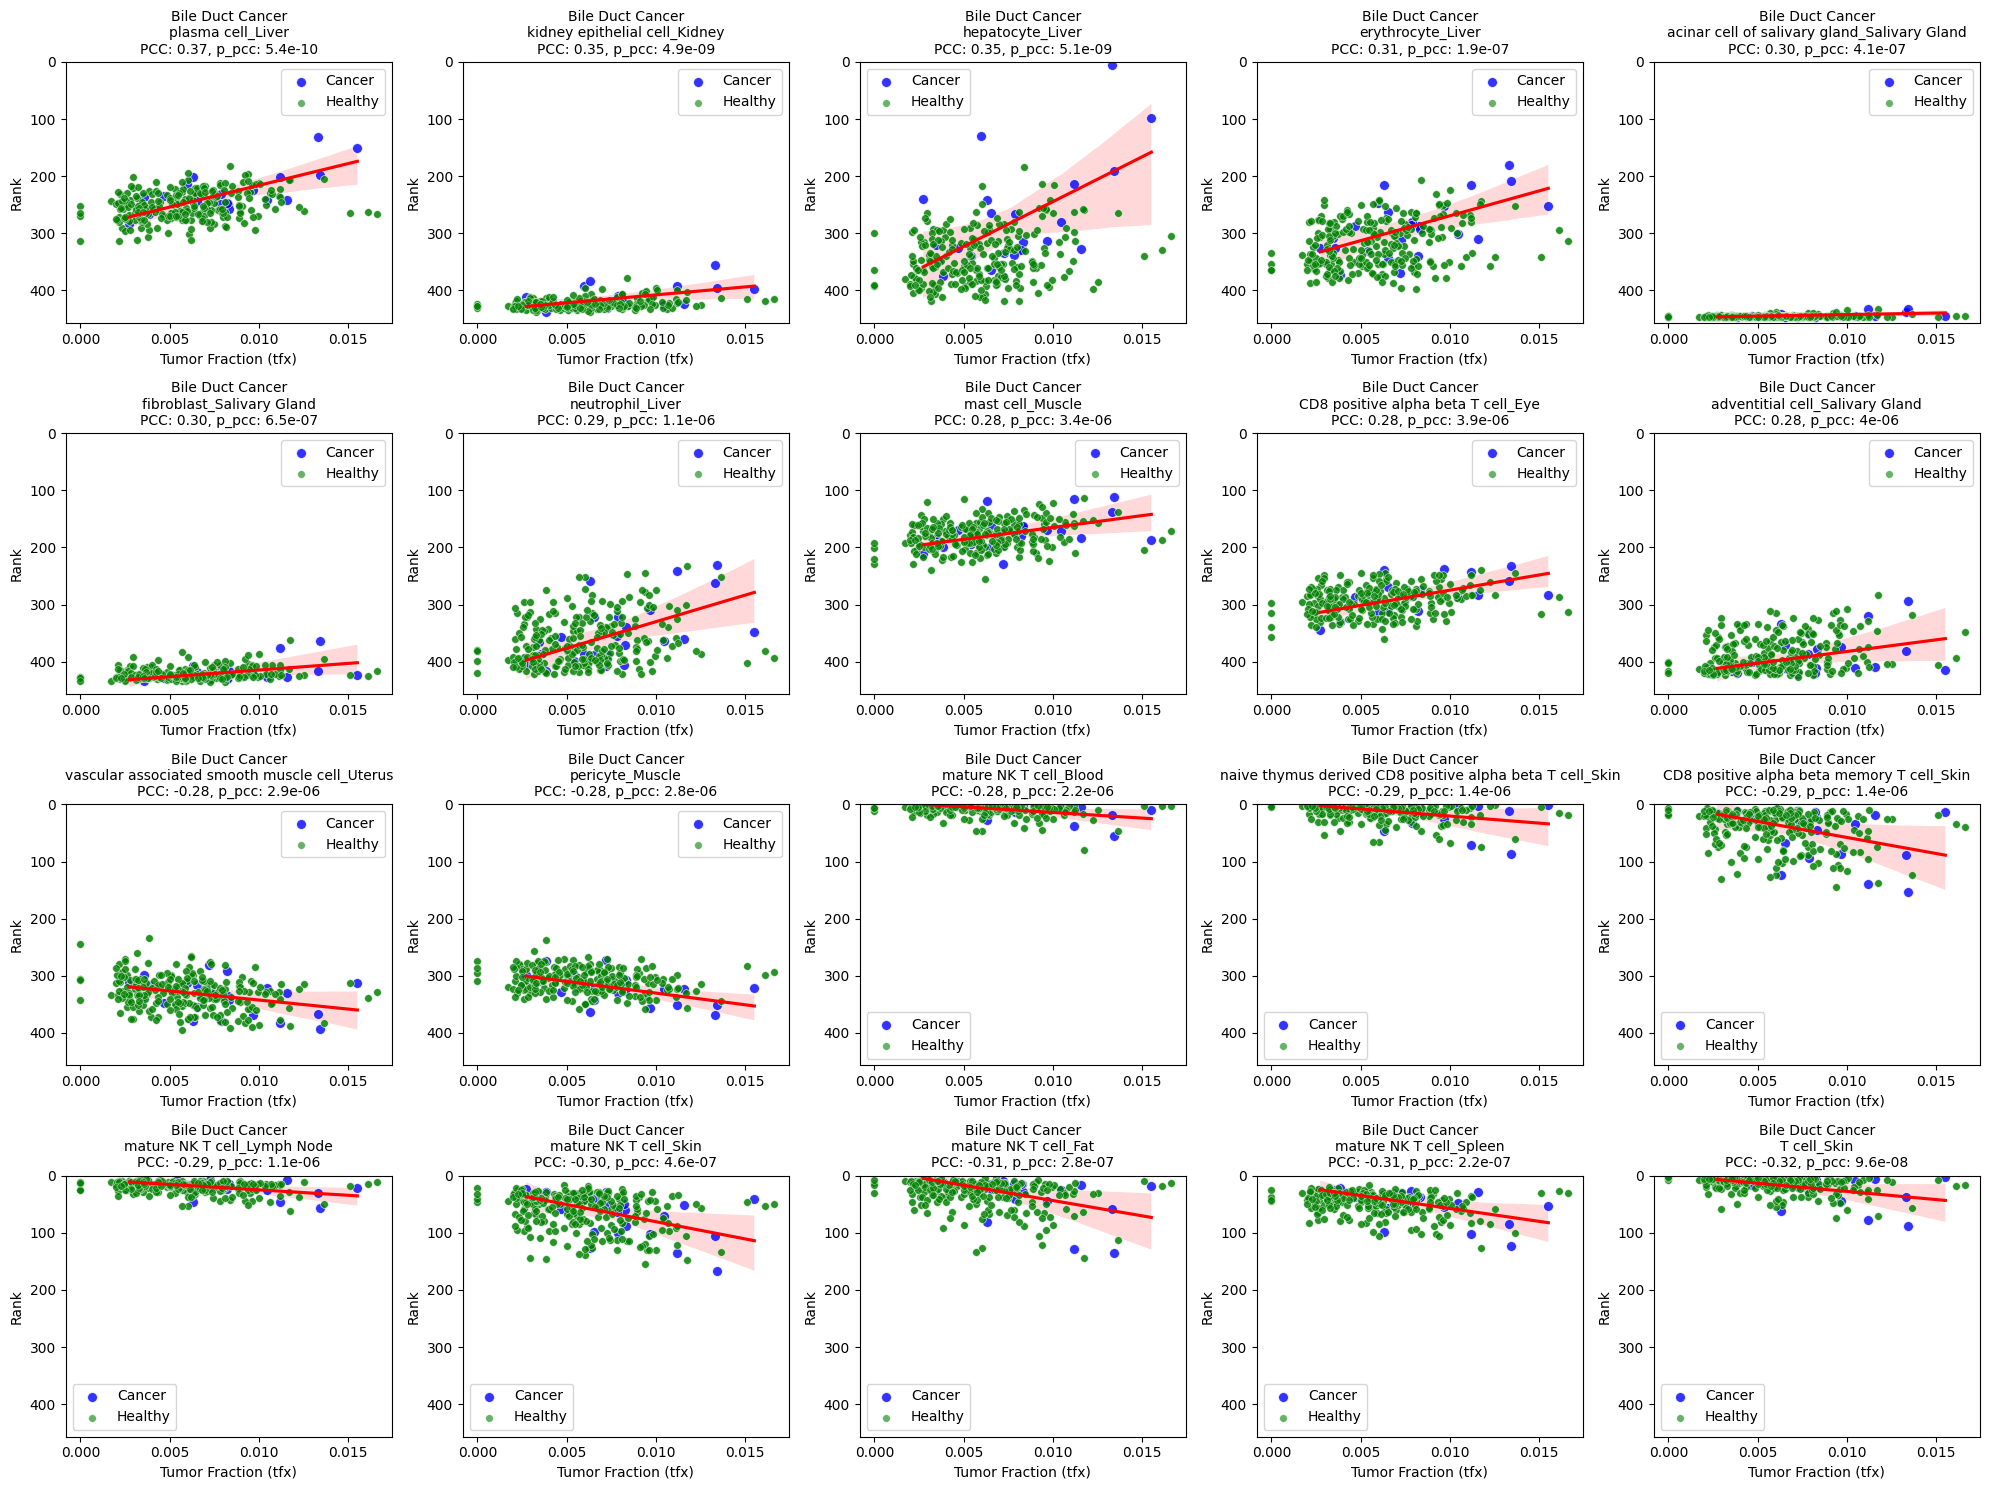

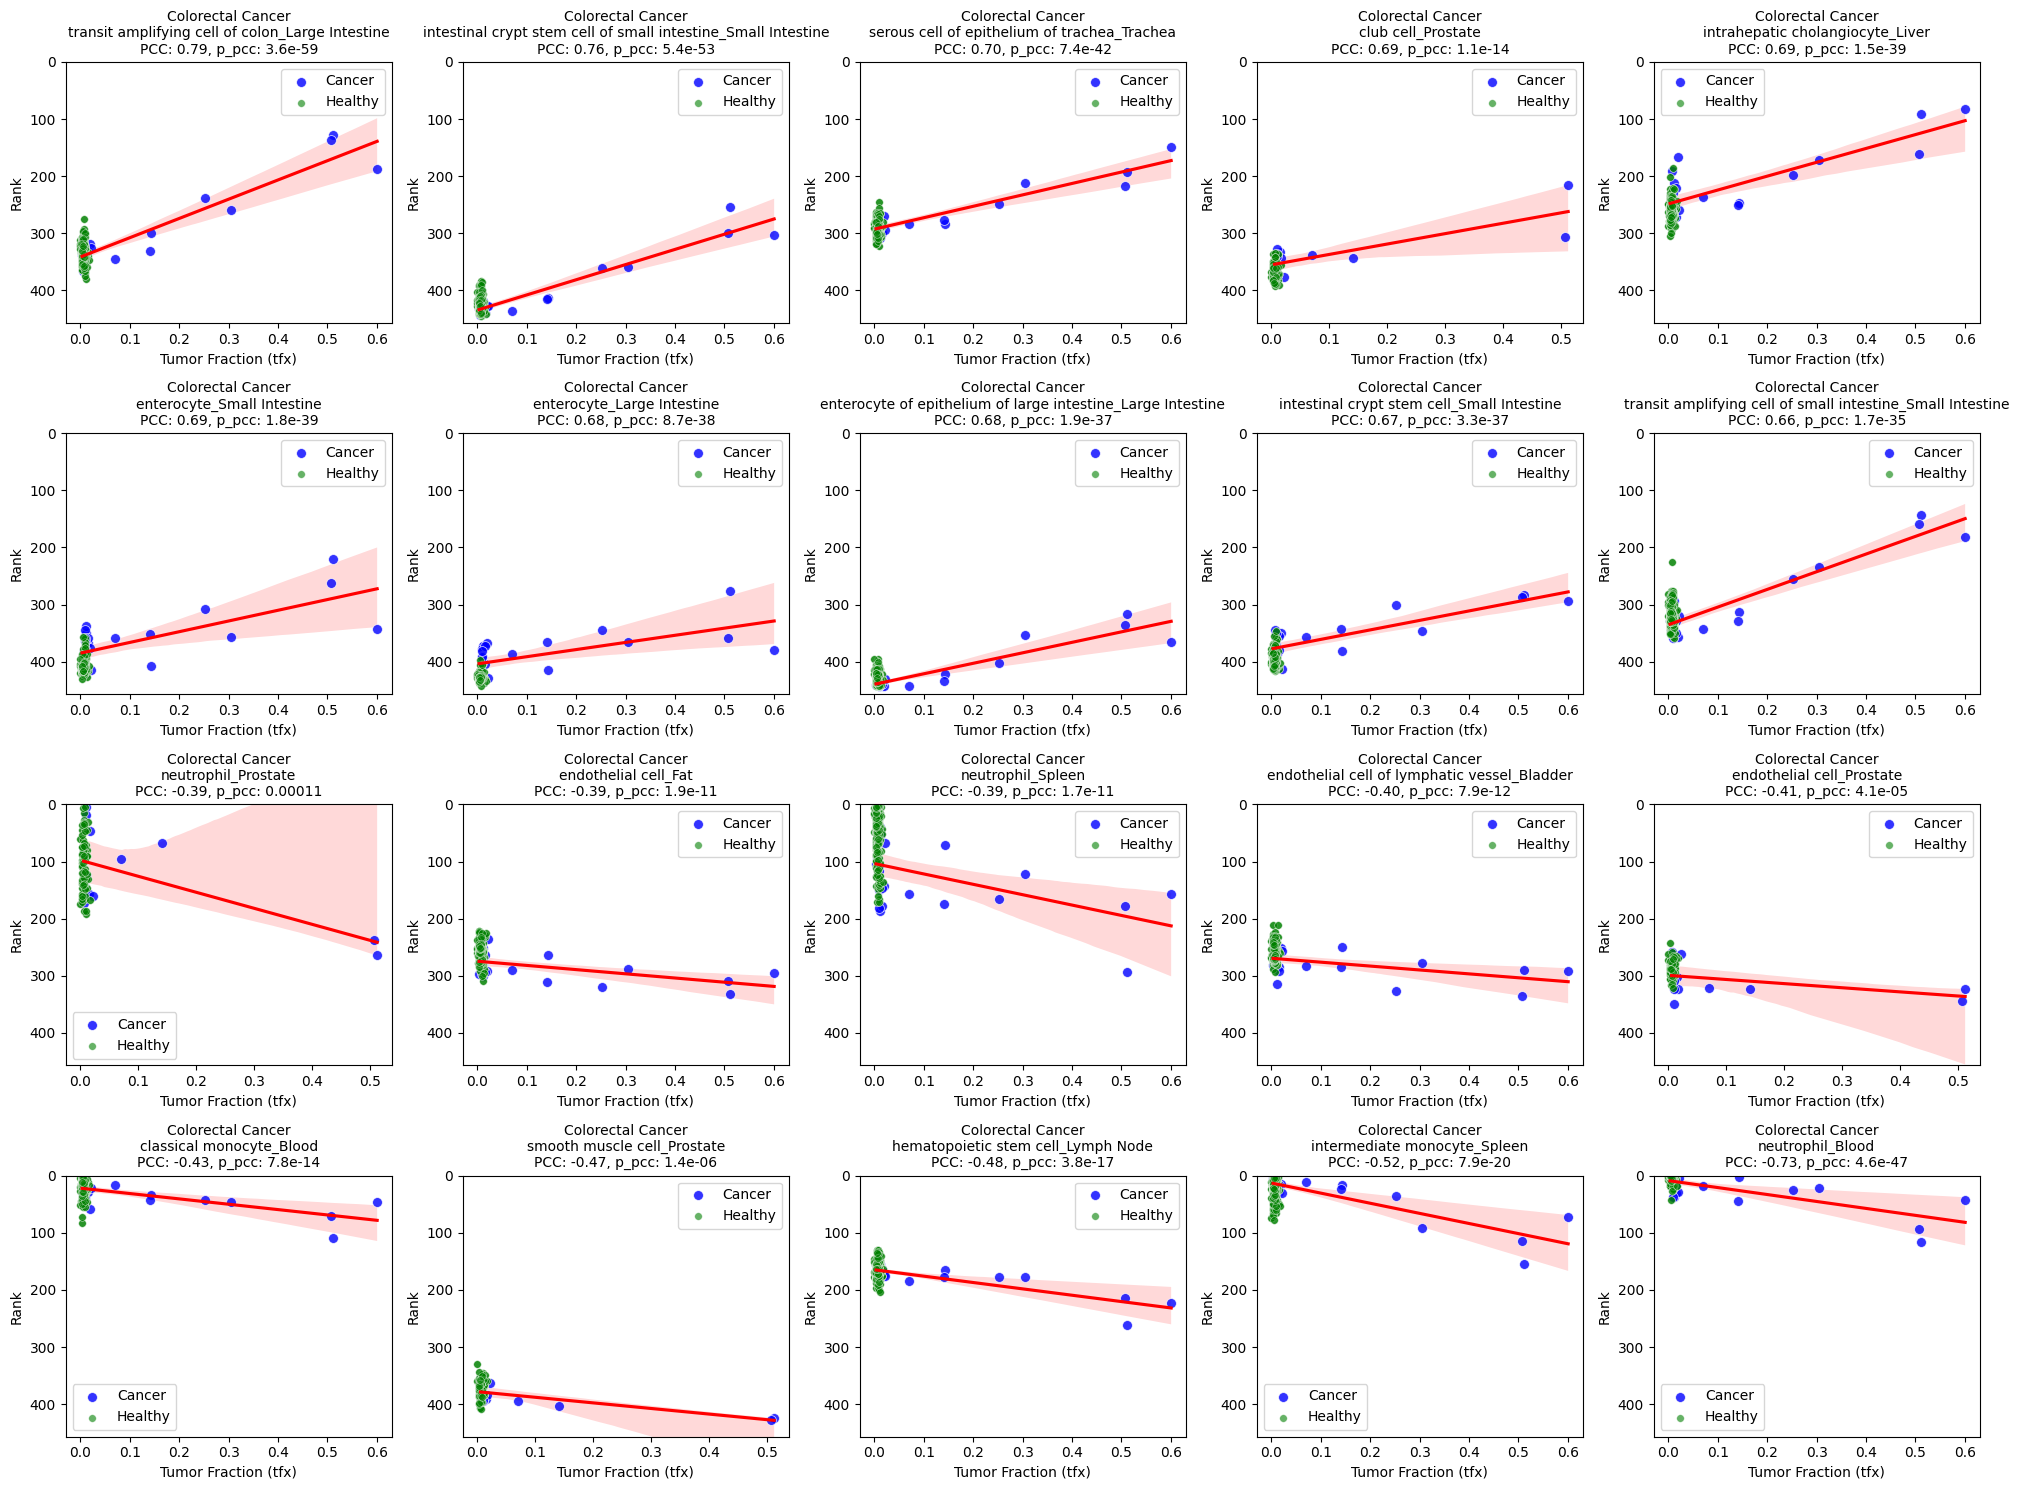

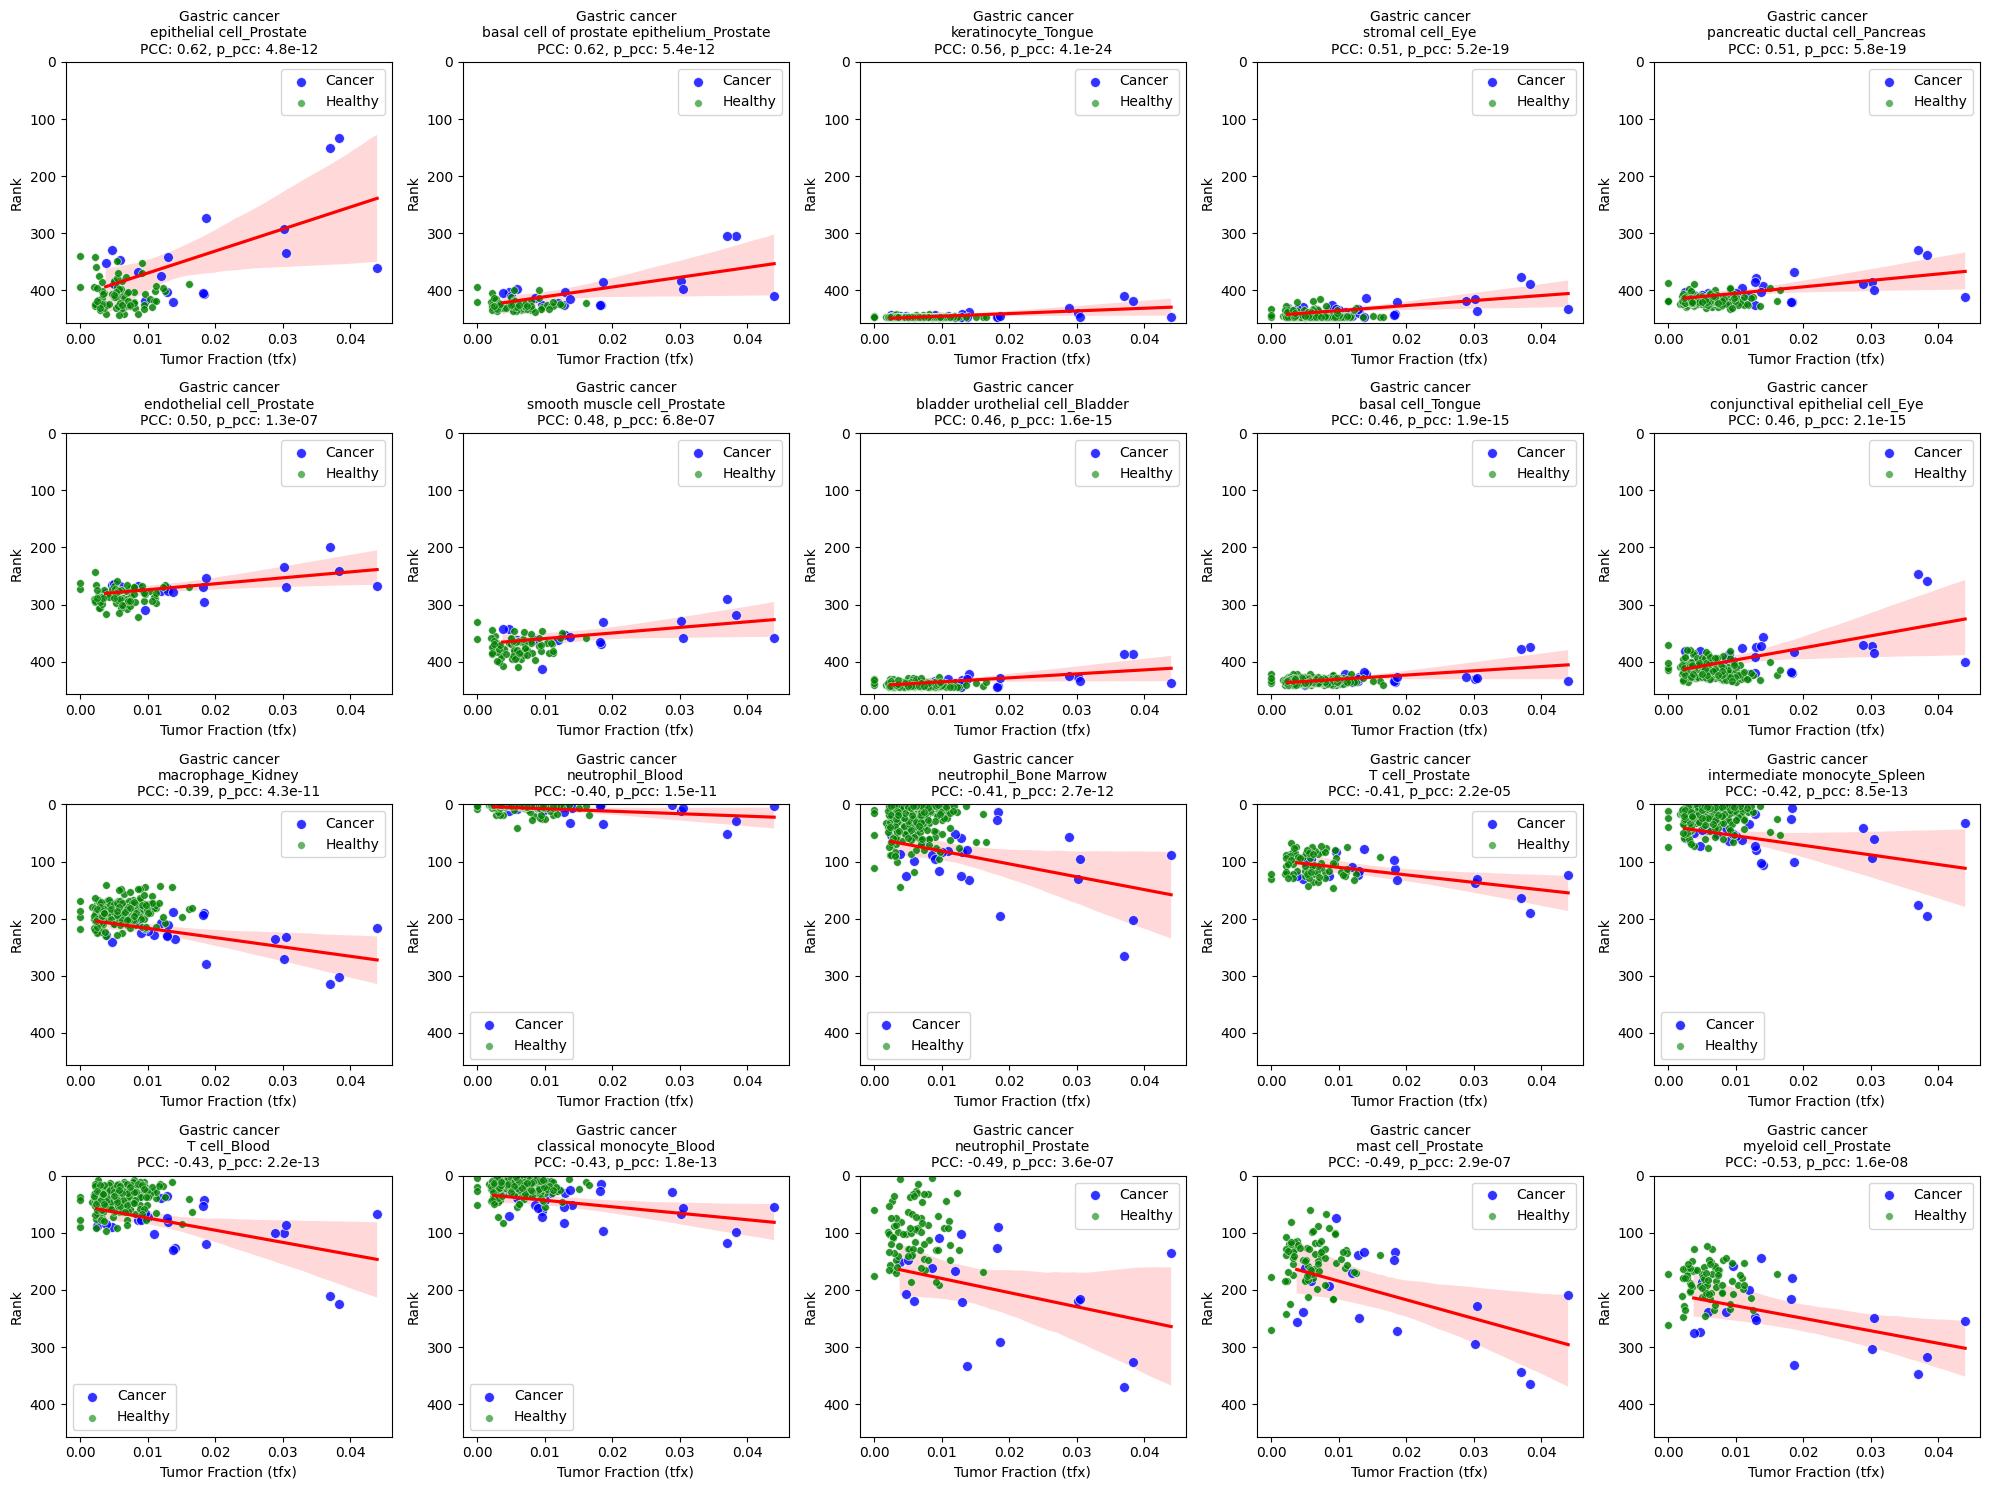

In [50]:
for cancer_type in dic.keys():
    print(cancer_type)
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(4, 5, figsize=(20, 15))

    # Flatten axs array for easy iteration
    axs = axs.flatten()
    plot_count = 0
    for cell_type_tissue in plot_dic[cancer_type].keys():
        p_value_pcc = plot_dic[cancer_type][cell_type_tissue]['p_value']
        PCC = plot_dic[cancer_type][cell_type_tissue]['PCC']
        df = plot_dic[cancer_type][cell_type_tissue]['df']

        # add healthy ranks if wanted
        healthy = data[(data['status'] == 'Healthy') & (data['cell_type_tissue'] == cell_type_tissue)]
        merged = pd.concat([df, healthy], ignore_index=True)

        # Set up the color palette for the two groups
        palette = {'Cancer': 'blue', 'Healthy': 'green'}

        # Plotting on the current subplot axis, where 'group' is the column representing your two groups
        # Regression plot, invisible points alpa = 0.0
        sns.regplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                    scatter_kws={'color': palette['Cancer'], 's': 20, 'alpha': 0.0},
                    line_kws={'color': 'red'}, ax=axs[plot_count])

        # Plotting for Cancer group - dummy - 
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                        color=palette['Cancer'], s=50, alpha=0.8, label='Cancer', ax=axs[plot_count])
        
        # Plotting for Healthy group
        sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == 'Healthy'],
                        color=palette['Healthy'], s=30, alpha=0.6, label='Healthy', ax=axs[plot_count])

        nr_cell_type_tissues = len(data['cell_type_tissue'].unique())
        # Set the title and labels for each subplot
        axs[plot_count].set_title(f'{cancer_type}\n{cell_type_tissue}\nPCC: {PCC:.2f}, p_pcc: {p_value_pcc:.2g}', fontsize=10)
        axs[plot_count].set_xlabel('Tumor Fraction (tfx)')
        axs[plot_count].set_ylabel('Rank')
        axs[plot_count].set_ylim(0, nr_cell_type_tissues + 10)
        axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
        
        plot_count += 1

    # Adjust display settings
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    plt.tight_layout()

    # Show the final plot
    # plt.show()
    # Define filename
    filename = os.path.join("/mnt/DATA3/timo/plots/PCC_linear_reg_plots/", f"{cancer_type.replace(' ', '_')}_linear_reg_plots.pdf")
    
    # Save the figure
    plt.savefig(filename, format="pdf", bbox_inches="tight")


In [9]:
# Assuming 'plot_dic' is your dictionary containing the top and bottom PCC values for each cancer type.
plot_data = []

# Loop through the dictionary to create a DataFrame
for cancer_type, sub_dic in plot_dic.items():
    for cell_type, values in sub_dic.items():
        plot_data.append({
            'CancerType': cancer_type,
            'CellType': cell_type,
            'PCC': values['PCC']
        })

# Create a DataFrame
df_plot = pd.DataFrame(plot_data)

# Check the structure of the data
print(df_plot)

        CancerType                             CellType       PCC
0      Lung Cancer  duct epithelial cell_Salivary Gland  0.475203
1      Lung Cancer                    basal cell_Tongue  0.442202
2      Lung Cancer              ionocyte_Salivary Gland  0.432041
3      Lung Cancer    endothelial cell of artery_Thymus  0.390772
4      Lung Cancer                T cell_Salivary Gland  0.375325
..             ...                                  ...       ...
65  Gastric cancer                         T cell_Blood -0.426116
66  Gastric cancer             classical monocyte_Blood -0.427506
67  Gastric cancer                  neutrophil_Prostate -0.485219
68  Gastric cancer                   mast cell_Prostate -0.488715
69  Gastric cancer                myeloid cell_Prostate -0.530803

[70 rows x 3 columns]


/tmp/ipykernel_1164084/3293808660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_viridis = cm.get_cmap("viridis_r")
/tmp/ipykernel_1164084/3293808660.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1164084/3293808660.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_1164084/3293808660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colo

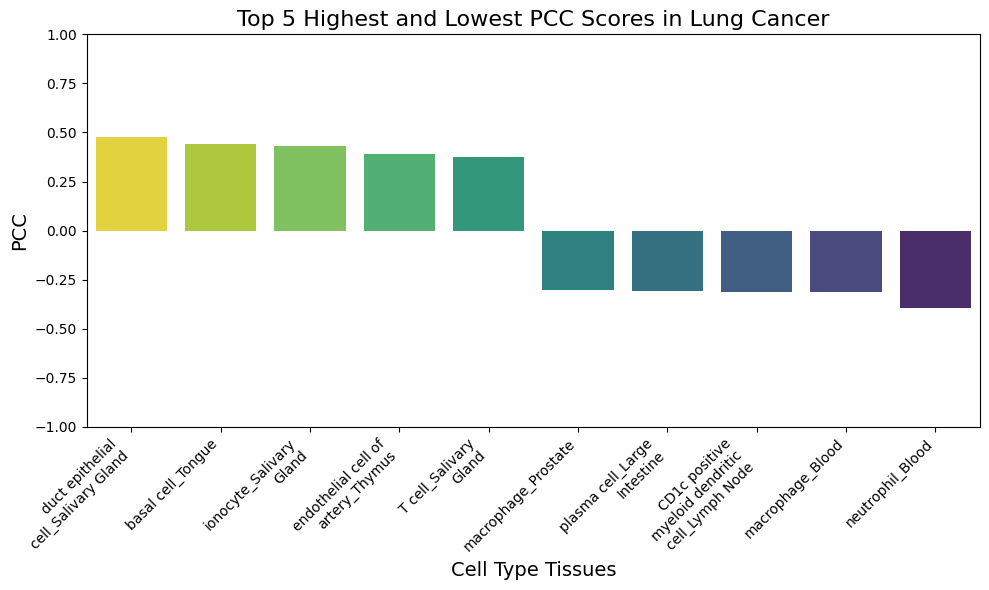

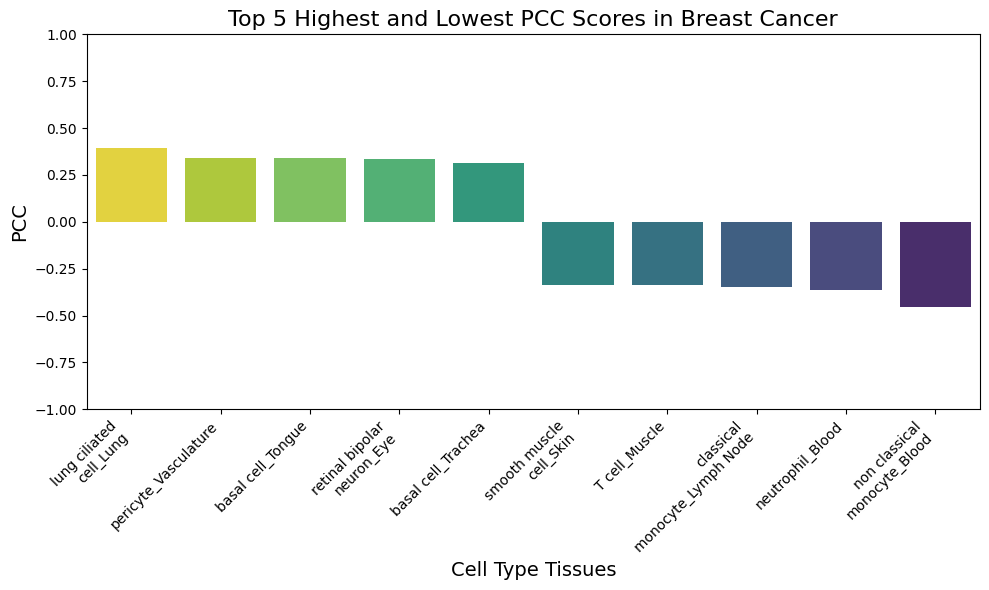

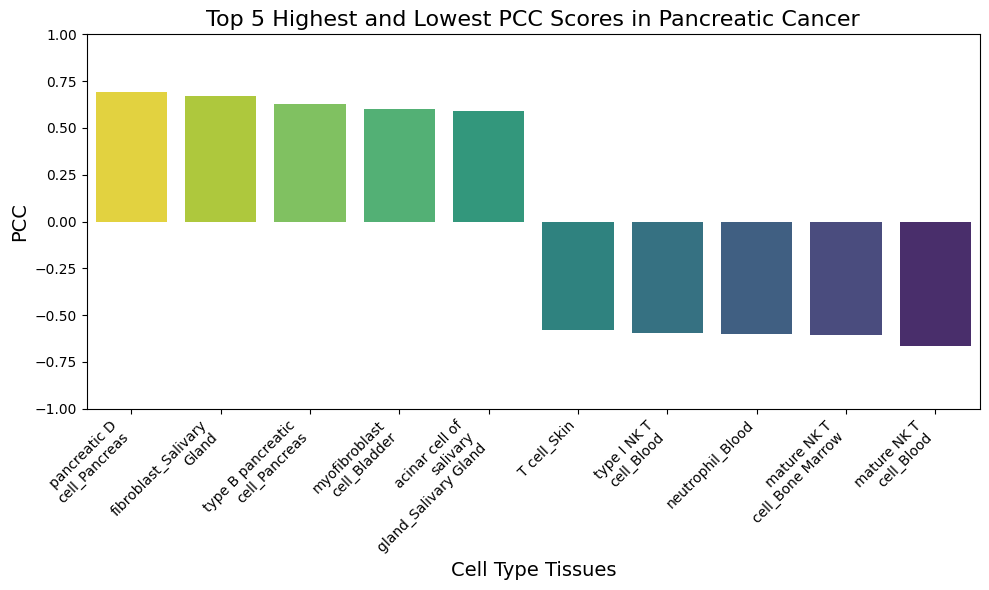

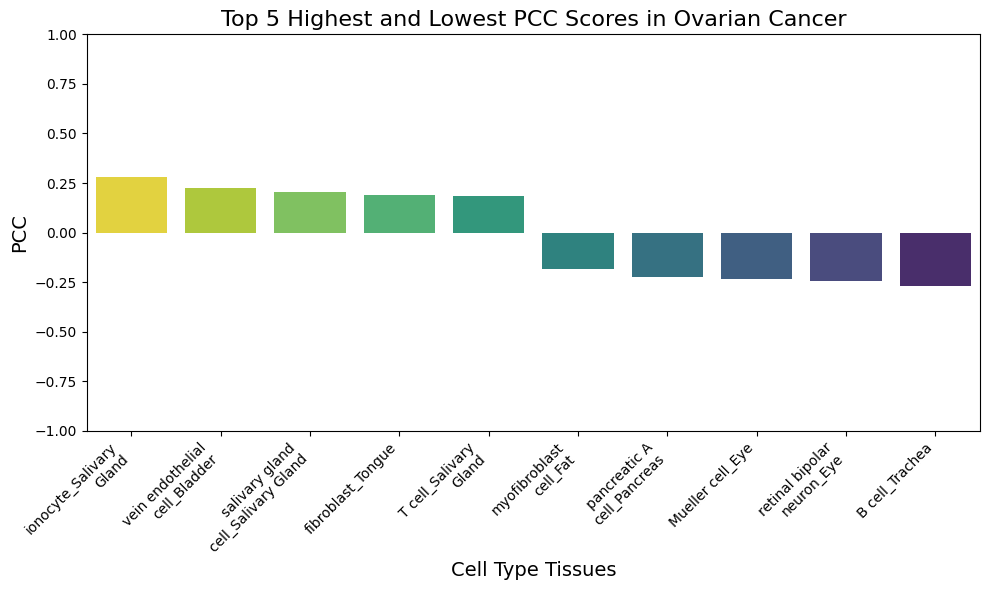

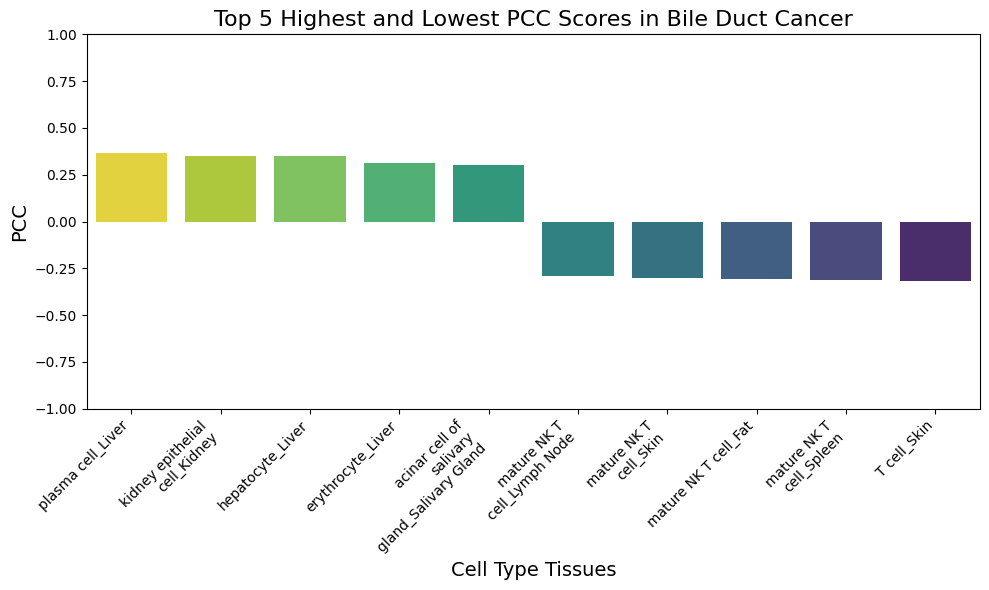

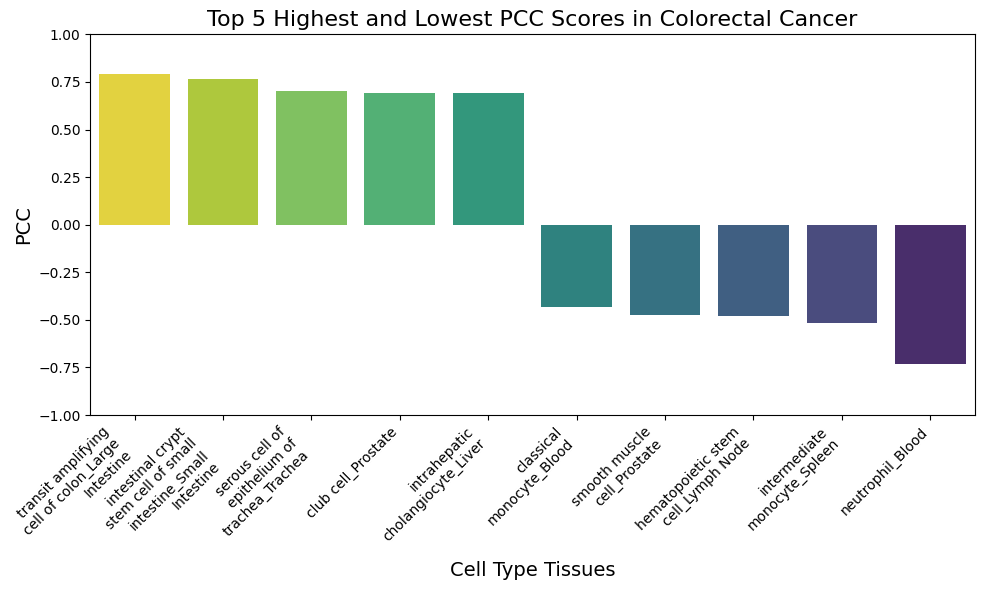

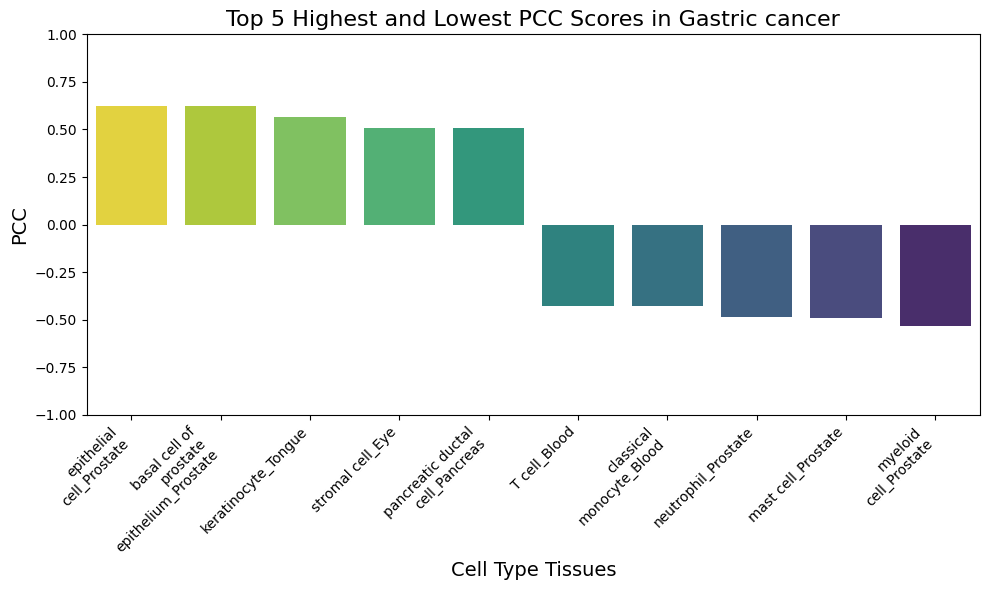

In [24]:
# Loop through each cancer type and create separate bar plots
unique_cancer_types = df_plot['CancerType'].unique()
plots = []
for cancer_type in unique_cancer_types:
    # Subset the data for the current cancer type
    subset = df_plot[df_plot['CancerType'] == cancer_type]

    # Create a reversed viridis colormap
    reversed_viridis = cm.get_cmap("viridis_r")
    
    # Generate colors based on the number of bars
    num_bars = subset.shape[0]
    colors = [reversed_viridis(i / num_bars) for i in range(num_bars)]
    
    # Create the plot figure
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis
    sns.barplot(
        data=subset, 
        x='CellType', 
        y='PCC', 
        palette=colors,
        ax=ax  # Use the created axis
    )
    


    # Wrap labels dynamically
    wrapped_labels = [textwrap.fill(label.get_text(), width=20) for label in ax.get_xticklabels()]
    ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=10) 
    ax.set_title(f'Top 5 Highest and Lowest PCC Scores in {cancer_type}', fontsize=16)
    ax.set_xlabel('Cell Type Tissues', fontsize=14)
    ax.set_ylabel('PCC', fontsize=14)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_ylim(-1, 1)
    ax.set_yticks(np.arange(-1, 1.25, 0.25))
    
    # Adjust layout and store the figure
    plt.tight_layout()
    plots.append(fig)  # Store figure in the list
    
    # Save the plot as a PDF
    cancer_type_label = cancer_type.replace(" ", "_")
    filename = os.path.join("/mnt/DATA3/timo/plots/PCC_scores_plots/", f"{cancer_type_label}_PCC_score_plot.pdf")
    plt.savefig(filename, format="pdf", bbox_inches="tight")

    # plt.close(fig)
    

In [16]:
from matplotlib.backends.backend_pdf import PdfPages

# Choose which plot to save (e.g., the first plot in the list)
fig_to_save = plots[5]  

# Save it as a PDF
fig_to_save.savefig("/mnt/DATA3/timo/plots/PCC_crc.pdf", format="pdf", bbox_inches="tight")


Colorectal Cancer


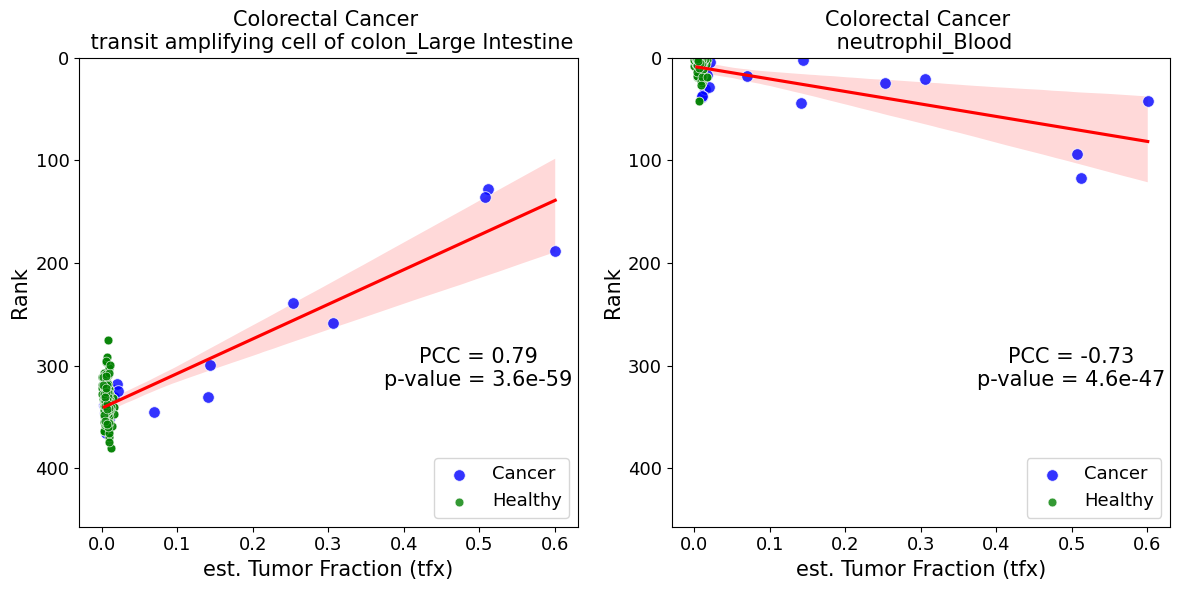

In [113]:
for cancer_type in dic.keys():
    if cancer_type == 'Colorectal Cancer':  # Focus on colorectal cancer type
        print(cancer_type)
        
        # Create a figure and a set of subplots (2 subplots for first and last cell types)
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figure size for 2 plots

        # Get the first and last cell type for colorectal cancer
        cell_types = list(plot_dic[cancer_type].keys())
        first_cell_type = cell_types[0]
        last_cell_type = cell_types[-1]

        # List of selected cell types (first and last)
        selected_cell_types = [first_cell_type, last_cell_type]
        
        # Loop over the selected cell types
        for plot_count, cell_type_tissue in enumerate(selected_cell_types):
            p_value_pcc = plot_dic[cancer_type][cell_type_tissue]['p_value']
            PCC = plot_dic[cancer_type][cell_type_tissue]['PCC']
            df = plot_dic[cancer_type][cell_type_tissue]['df']

            # Add healthy ranks if wanted
            healthy = data[(data['status'] == 'Healthy') & (data['cell_type_tissue'] == cell_type_tissue)]
            merged = pd.concat([df, healthy], ignore_index=True)

            # Set up the color palette for the two groups
            palette = {'Cancer': 'blue', 'Healthy': 'green'}

            # Plotting on the current subplot axis, where 'group' is the column representing your two groups
            sns.regplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                        scatter_kws={'color': palette['Cancer'], 's': 20, 'alpha': 0.0},
                        line_kws={'color': 'red'}, ax=axs[plot_count])

            # Plotting for Cancer group - dummy
            sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == cancer_type],
                            color=palette['Cancer'], s=70, alpha=0.8, label='Cancer', ax=axs[plot_count])

            # Plotting for Healthy group
            sns.scatterplot(x='tfx', y='rank', data=merged[merged['status'] == 'Healthy'],
                            color=palette['Healthy'], s=40, alpha=0.8, label='Healthy', ax=axs[plot_count])

            nr_cell_type_tissues = len(data['cell_type_tissue'].unique())
            # Set the title to bold
            axs[plot_count].set_title(f'{cancer_type} \n {cell_type_tissue}', fontsize=15)#, fontweight='bold')

            # Insert PCC and p-value inside the plot area
            axs[plot_count].text(0.8, 0.35, f'PCC = {PCC:.2f}', fontsize=15, ha='center', transform=axs[plot_count].transAxes)
            axs[plot_count].text(0.8, 0.30, f'p-value = {p_value_pcc:.2g}', fontsize=15, ha='center', transform=axs[plot_count].transAxes)

            # Set the labels for x and y axes
            axs[plot_count].set_xlabel('est. Tumor Fraction (tfx)', fontsize=15)
            axs[plot_count].set_ylabel('Rank', fontsize=15)
            axs[plot_count].set_ylim(0, nr_cell_type_tissues + 10)
            axs[plot_count].invert_yaxis()  # Invert y-axis to show higher rank at the top
            axs[plot_count].tick_params(axis='both', which='major', labelsize=13)
            axs[plot_count].legend(fontsize=13, loc = "lower right")

        # Adjust display settings
        pd.set_option('display.width', 1000)
        pd.set_option('display.max_columns', None)
        plt.tight_layout()

        # Define filename
        filename = os.path.join("/mnt/DATA3/timo/plots/PCC_linear_reg_plots/", f"{cancer_type.replace(' ', '_')}_first_last_linear_reg_plots.pdf")
        
        # Save the figure
        plt.savefig(filename, format="pdf", bbox_inches="tight")


In [59]:
unique_cancer_types

array(['Lung Cancer', 'Breast Cancer', 'Pancreatic Cancer',
       'Ovarian Cancer', 'Bile Duct Cancer', 'Colorectal Cancer',
       'Gastric cancer'], dtype=object)

/tmp/ipykernel_1164084/1620282475.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_viridis = cm.get_cmap("viridis_r")
/tmp/ipykernel_1164084/1620282475.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1164084/1620282475.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=15)
/tmp/ipykernel_1164084/1620282475.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.co

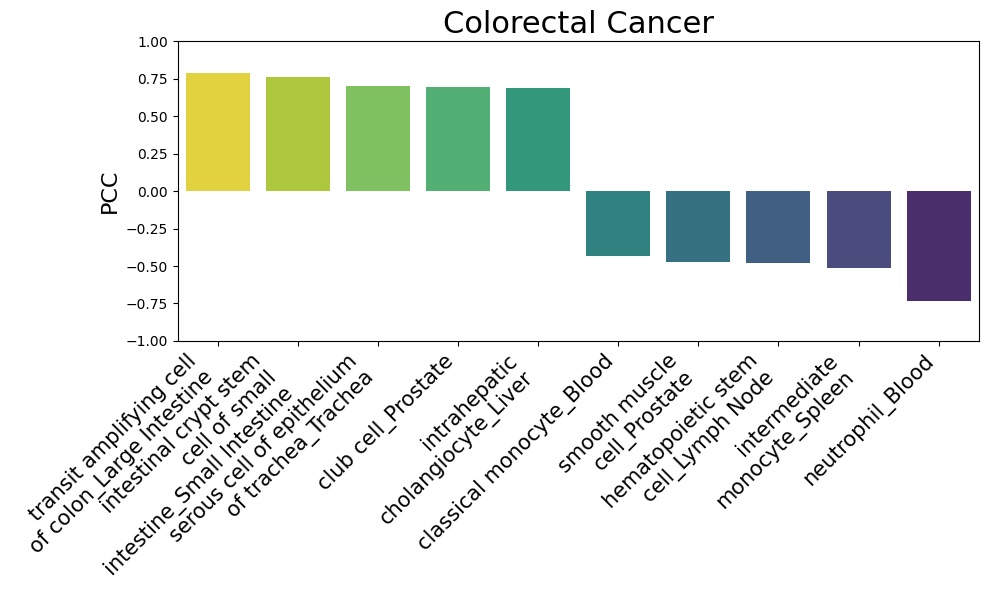

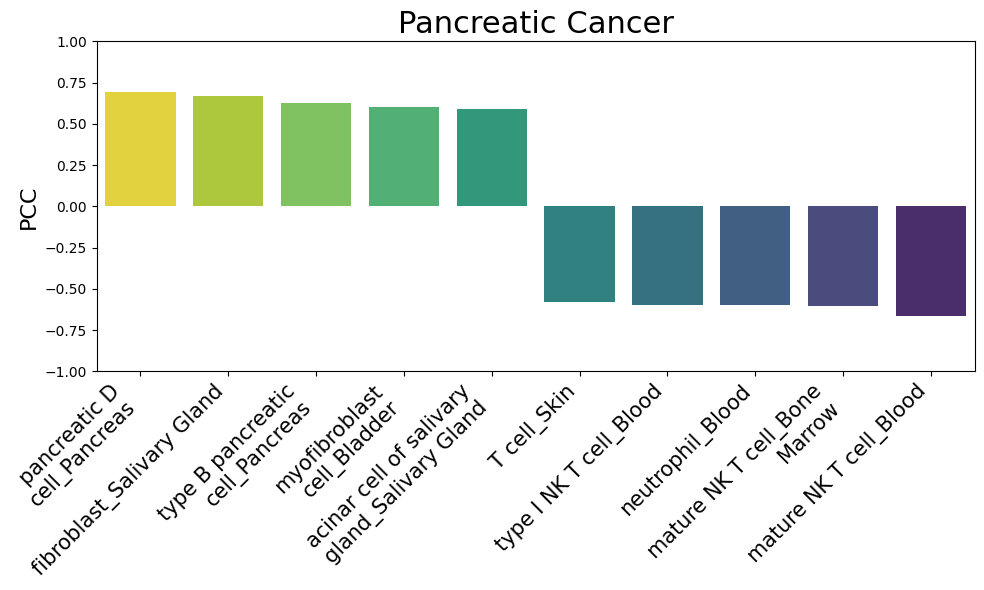

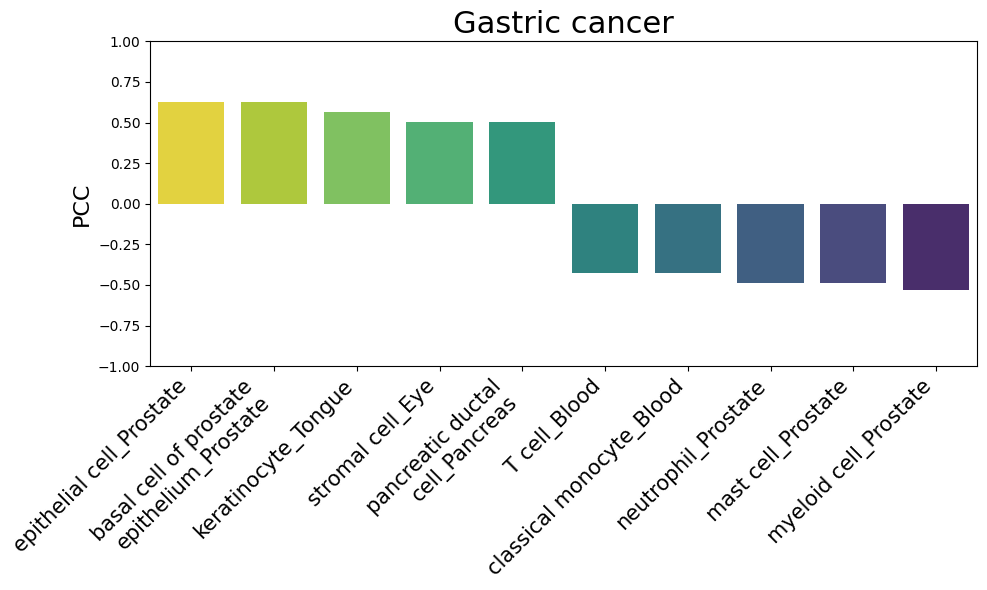

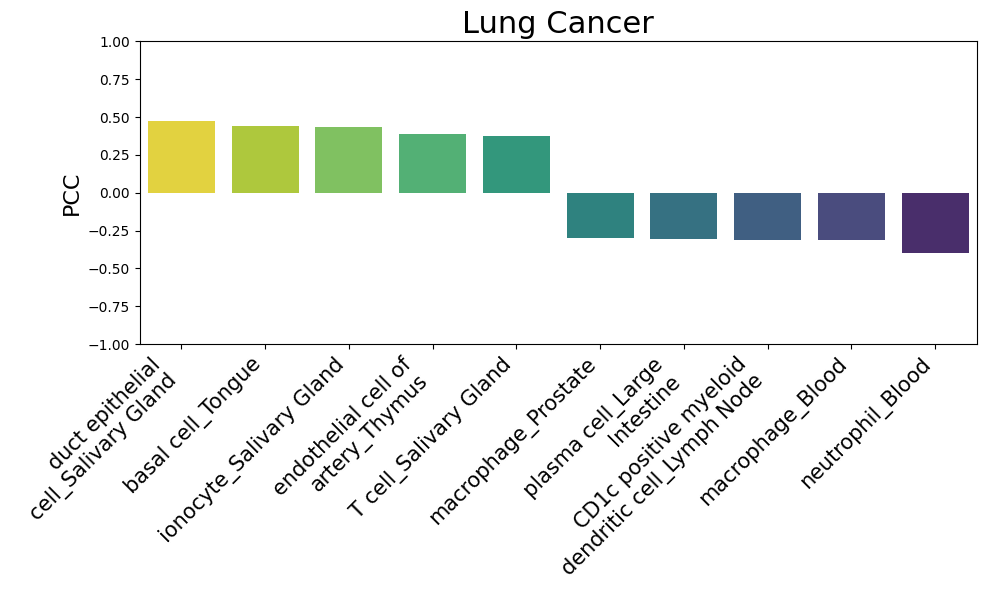

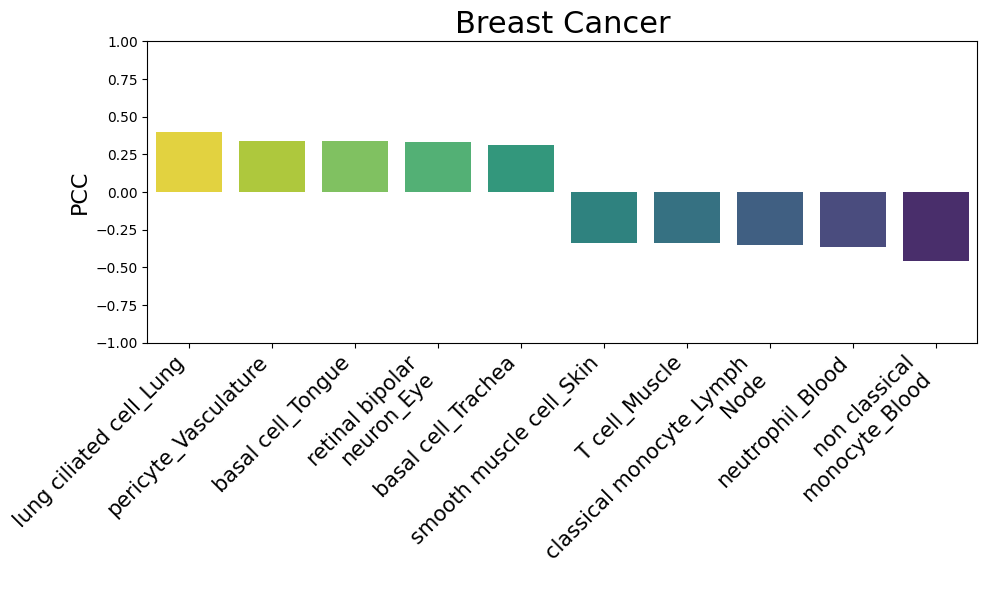

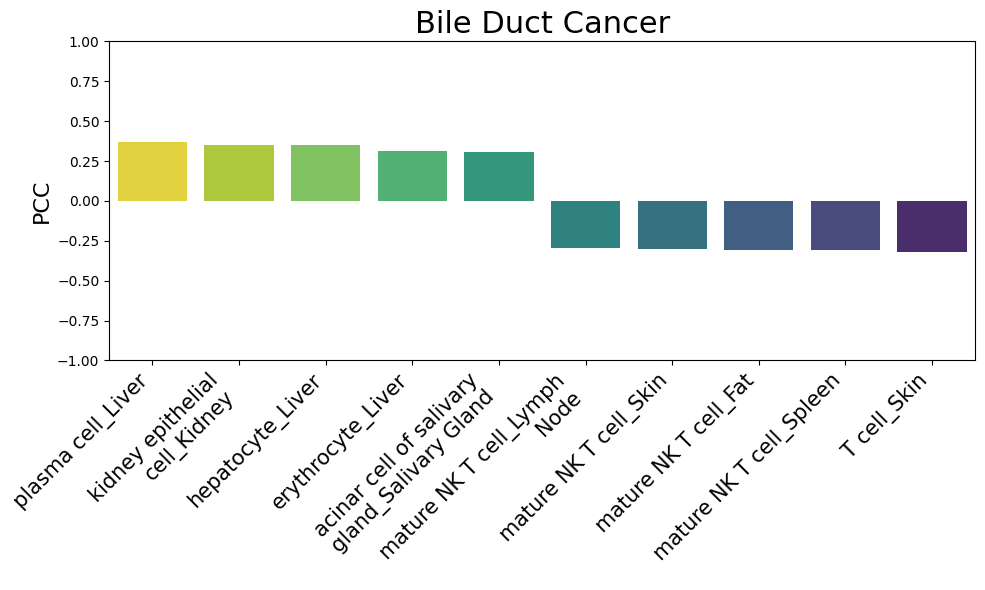

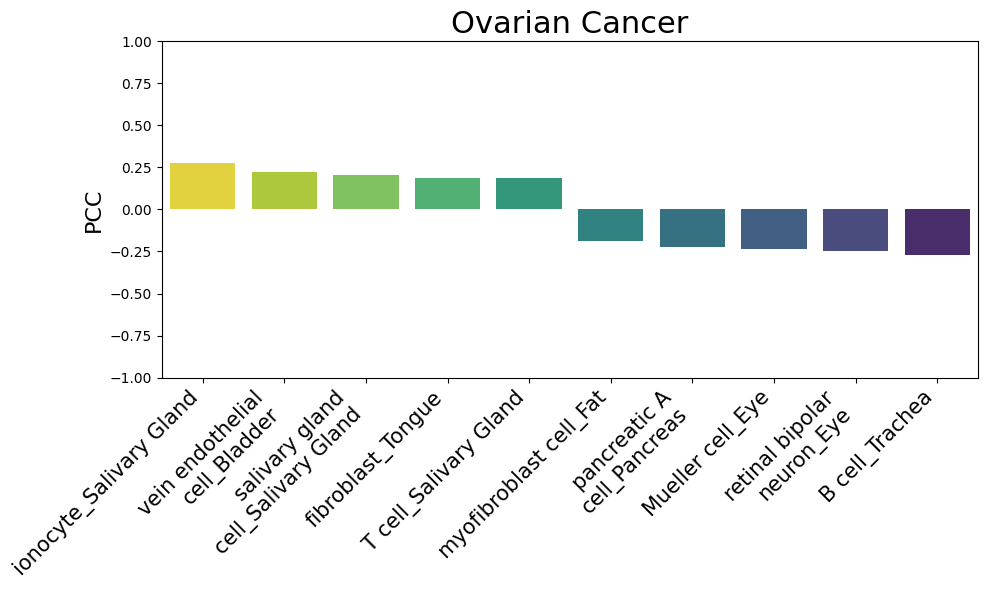

In [66]:
# Loop through each cancer type and create separate bar plots
unique_cancer_types = df_plot['CancerType'].unique()
costum_order = ["Colorectal Cancer", "Pancreatic Cancer", "Gastric cancer",
                  "Lung Cancer", "Breast Cancer", "Bile Duct Cancer", "Ovarian Cancer"]
subplots_list = []
for cancer_type in costum_order:
    # Subset the data for the current cancer type
    subset = df_plot[df_plot['CancerType'] == cancer_type]

    # Create a reversed viridis colormap
    reversed_viridis = cm.get_cmap("viridis_r")
    
    # Generate colors based on the number of bars
    num_bars = subset.shape[0]
    colors = [reversed_viridis(i / num_bars) for i in range(num_bars)]
    
    # Create the plot figure
    fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis
    sns.barplot(
        data=subset, 
        x='CellType', 
        y='PCC', 
        palette=colors,
        ax=ax  # Use the created axis
    )
    

    # Wrap labels dynamically
    wrapped_labels = [textwrap.fill(label.get_text(), width=25) for label in ax.get_xticklabels()]
    ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=15) 
    ax.set_title(f'{cancer_type}', fontsize=22)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('PCC', fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_ylim(-1, 1)
    ax.set_yticks(np.arange(-1, 1.25, 0.25))
    
    # Adjust layout and store the figure
    plt.tight_layout()
    subplots_list.append(fig)  # Store figure in the list
    
    # Save the plot as a PDF
    cancer_type_label = cancer_type.replace(" ", "_")
    # filename = os.path.join("/mnt/DATA3/timo/plots/PCC_scores_plots/", f"{cancer_type_label}_PCC_score_plot.pdf")
    # plt.savefig(filename, format="pdf", bbox_inches="tight")

    # plt.close(fig)
    

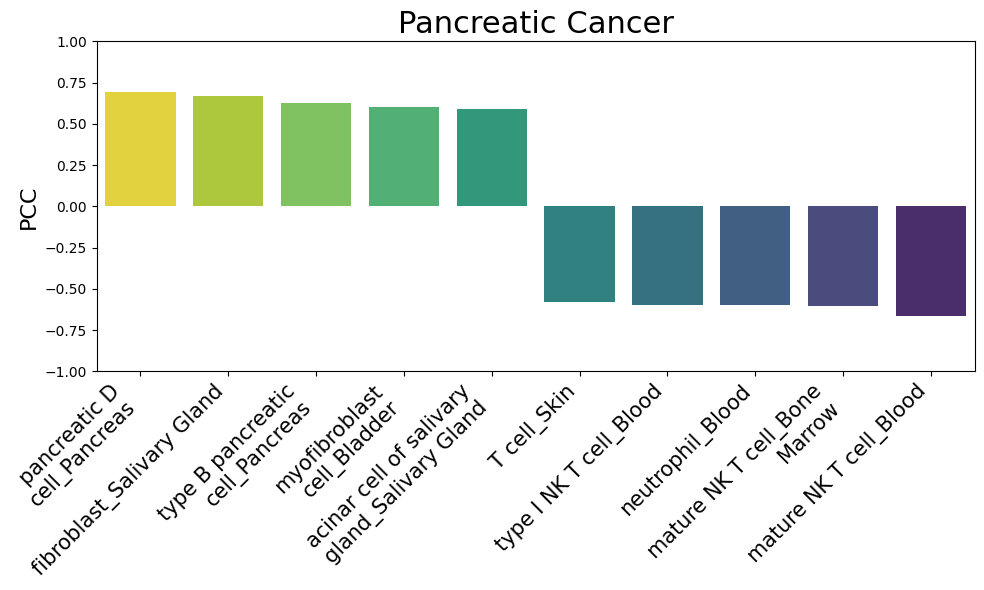

In [74]:
subplots_list[1]

/tmp/ipykernel_1164084/2197337508.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_viridis = cm.get_cmap("viridis_r")
/tmp/ipykernel_1164084/2197337508.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1164084/2197337508.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=60, ha='right', fontsize=16)
/tmp/ipykernel_1164084/2197337508.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.co

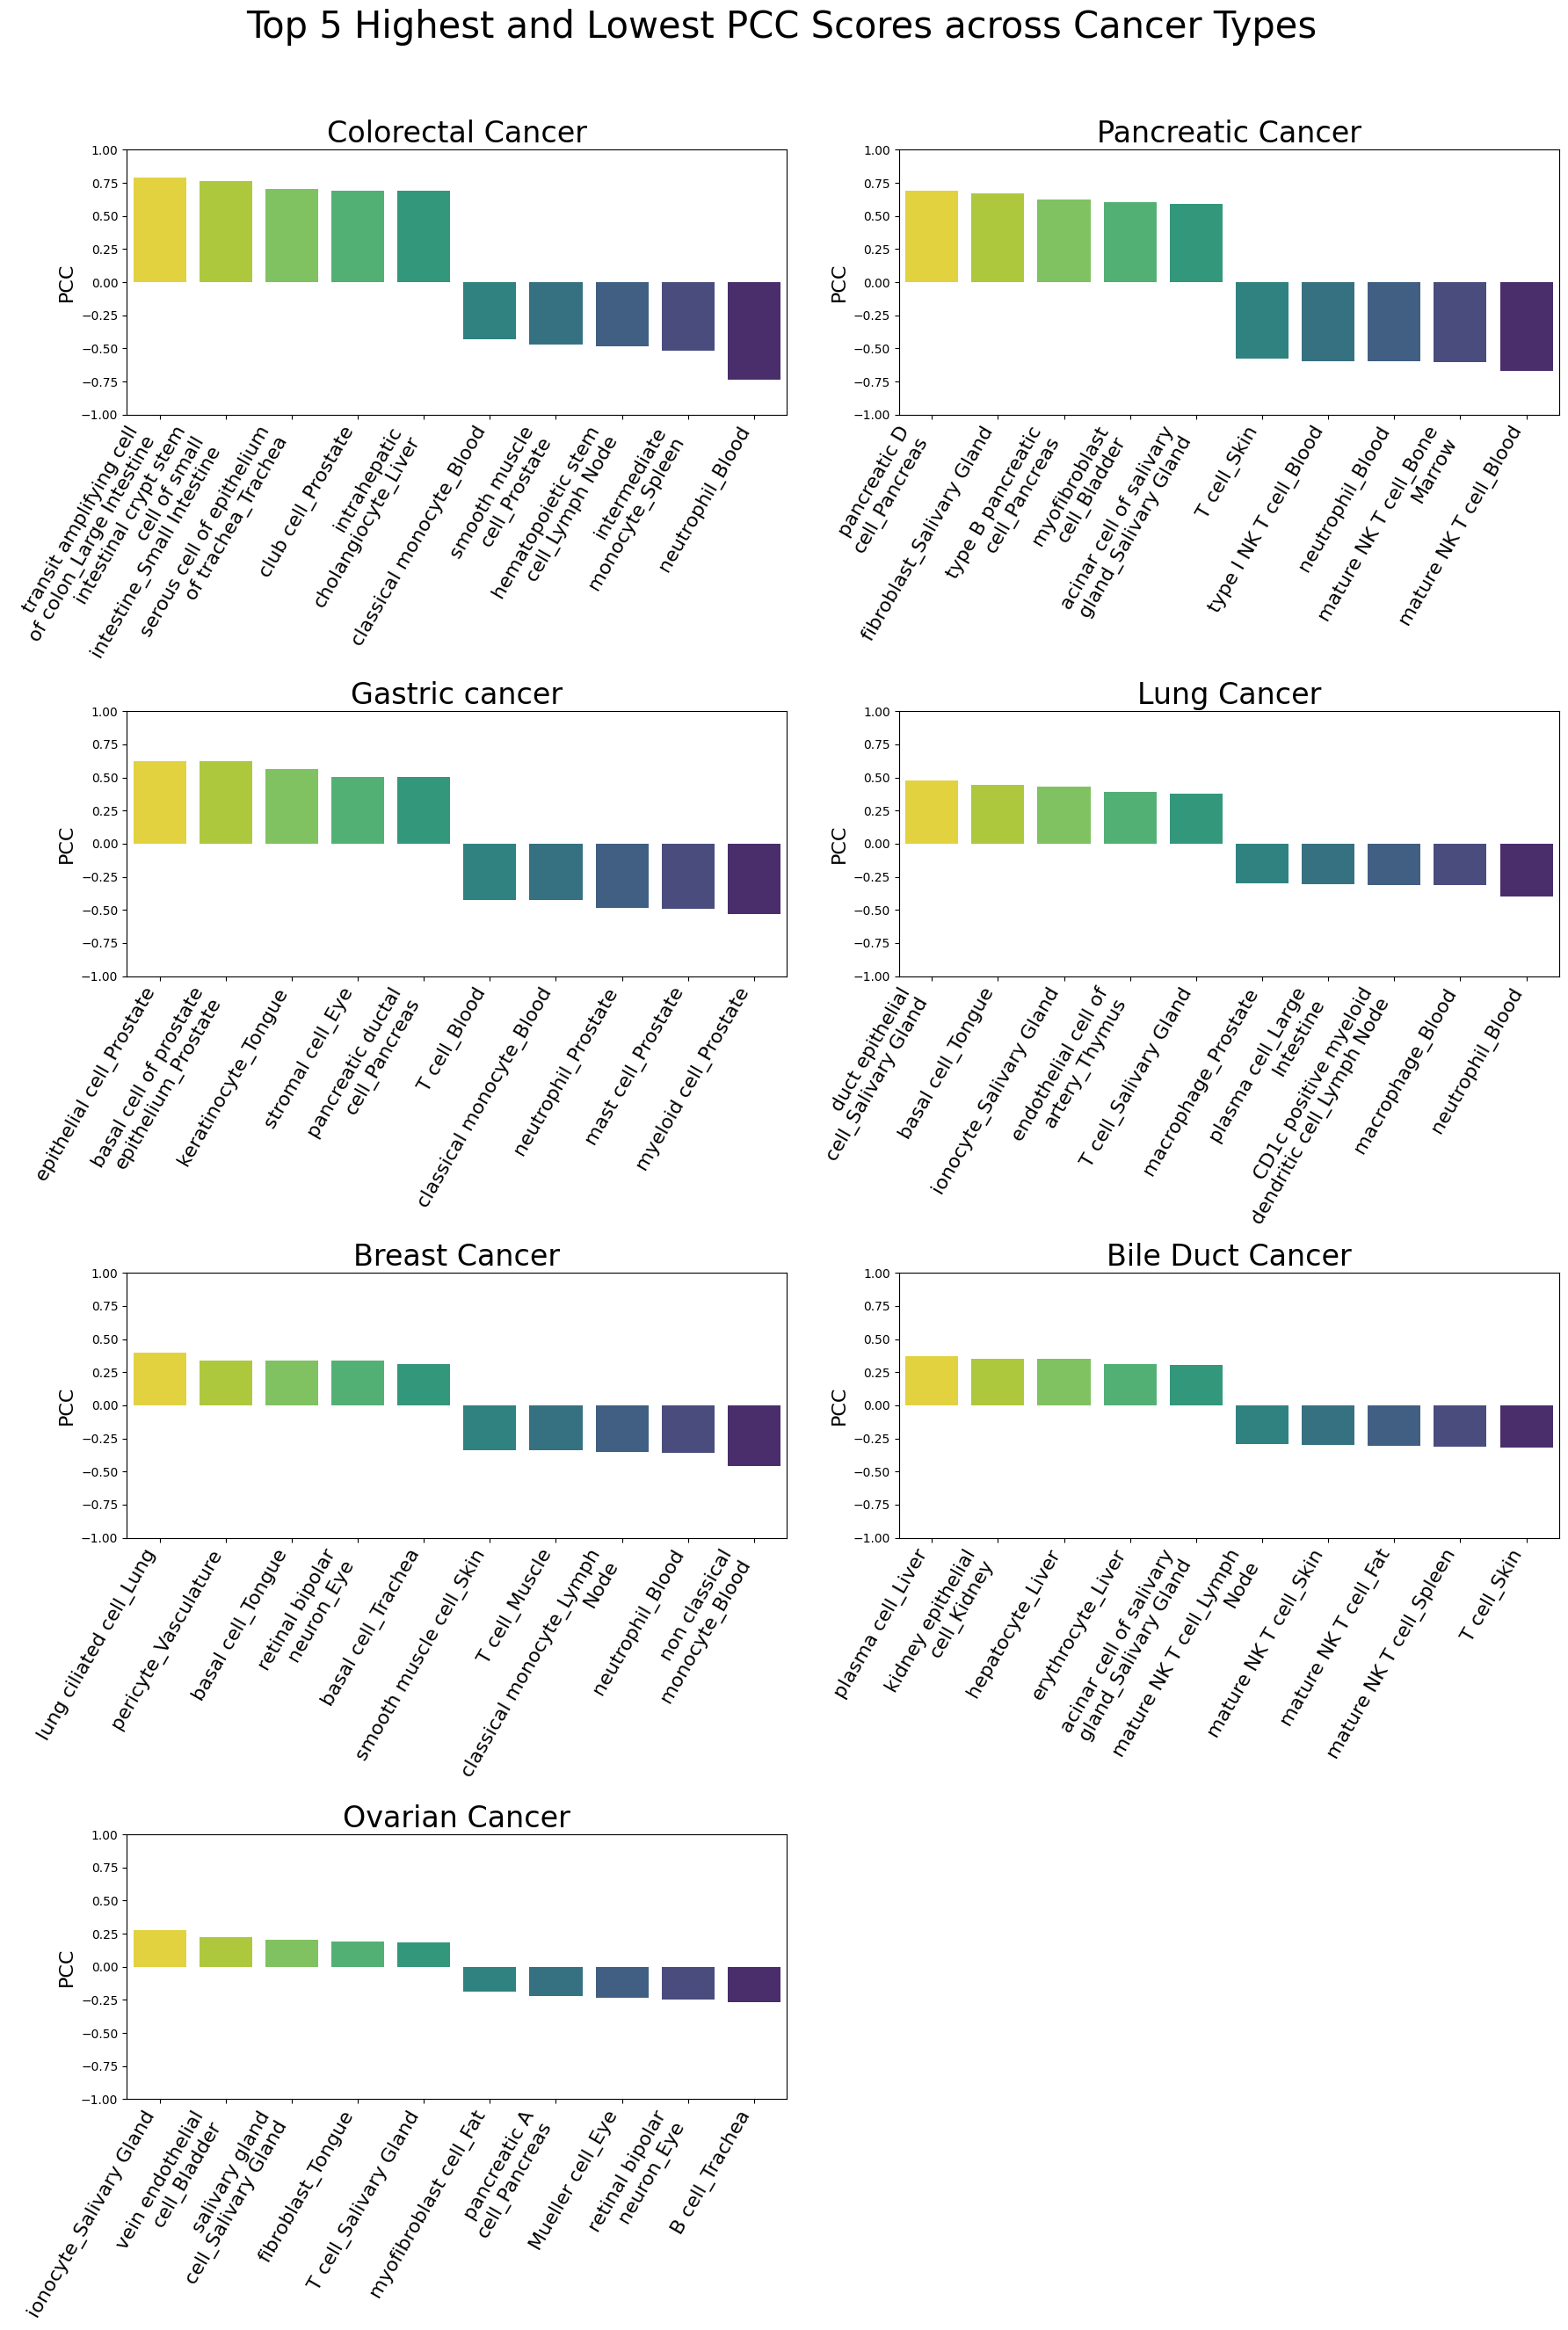

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textwrap
import matplotlib.cm as cm

# Create a 4x2 grid of subplots (7 plots + 1 empty space)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 27))  # Adjust figsize as needed 18, 25
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop through each cancer type and create separate bar plots
unique_cancer_types = df_plot['CancerType'].unique()
costum_order = ["Colorectal Cancer", "Pancreatic Cancer", "Gastric cancer",
                "Lung Cancer", "Breast Cancer", "Bile Duct Cancer", "Ovarian Cancer"]
subplots_list = []

for i, cancer_type in enumerate(costum_order):
    # Subset the data for the current cancer type
    subset = df_plot[df_plot['CancerType'] == cancer_type]

    # Create a reversed viridis colormap
    reversed_viridis = cm.get_cmap("viridis_r")
    
    # Generate colors based on the number of bars
    num_bars = subset.shape[0]
    colors = [reversed_viridis(i / num_bars) for i in range(num_bars)]
    
    # Create the plot figure
    ax = axes[i]  # Assign the appropriate axis from the grid
    sns.barplot(
        data=subset, 
        x='CellType', 
        y='PCC', 
        palette=colors,
        ax=ax  # Use the assigned axis
    )

    # Wrap labels dynamically
    wrapped_labels = [textwrap.fill(label.get_text(), width=25) for label in ax.get_xticklabels()]
    ax.set_xticklabels(wrapped_labels, rotation=60, ha='right', fontsize=16) 
    ax.set_title(f'{cancer_type}', fontsize=24)
    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel('PCC', fontsize=16)
    ax.set_ylim(-1, 1)
    ax.set_yticks(np.arange(-1, 1.25, 0.25))

# Hide the last empty subplot if it's not used
if len(costum_order) < len(axes):
    axes[-1].axis("off")  # Hide the last axis if there are fewer than 8 plots

# Add a title for the whole plot
fig.suptitle("Top 5 Highest and Lowest PCC Scores across Cancer Types", fontsize=30)

# Adjust layout to make space for the main title
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle

# Show the final plot
plt.show()


In [103]:
fig.savefig('/mnt/DATA3/timo/plots/PCC_scores_across_cancer_types.pdf', format='pdf', bbox_inches='tight', dpi=300)
